Some code in this notebook has been adapted from the work of Zhongy et al. and Greydanus et al. and from the report and code of Jonas Perolini.

Their code is available in the following repositories :[
Symplectic-ODENet](https://github.com/Physics-aware-AI/Symplectic-ODENet) and [hamiltonian-nn](https://github.com/greydanus/hamiltonian-nn)


# Imports & Setting up directories

In [401]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:  
    PATH = './' # './drive/MyDrive/1_SP_Ham_func/'
    from google.colab import drive
    drive.mount('/content/drive')

    %cd /content/drive/MyDrive/1_SP_Ham_func/
    %pip install torchdiffeq
else:
    import sys; sys.path.insert(0, '..') 
    import os
    PATH = '../'

In [402]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader, random_split
import torch

from torch.optim.lr_scheduler import LinearLR

from torchdiffeq import odeint_adjoint as odeint_adjoint 
# func must be a nn.Module when using the adjoint method
from torchdiffeq import odeint as odeint

import time as time
import json

# setting seeds

# Create requirements

In [403]:
# %pip install nbconvert
# # converts notebook to .py file for pipreqs
# !jupyter nbconvert --output-dir="./" --to script furuta_pendulum.ipynb 

# %pip install pipreqs
# # creates the requirement file
# !pipreqs 
# os.remove('./furuta_pendulum.py')  # deletes the .py file

# Code

## dynamics

In [404]:
def furuta_H(q1, p1, q2, p2, g, Jr, Lr, Mp, Lp):
    '''
    Description:
      Hamiltonian function for the Furuta pendulum 
    Inputs : 
      - q1,p1,q2,p2 (tensors) : Generalized coordinates 
    Outputs : 
      - H (tensor) : Hamiltonian function 
    Credits : 
      - Equations & constants are from Jonas's report
    '''

    # system constants
    Jp = (1/12)*Mp*Lp**2

    # function constants
    C1 = Jr + Mp*Lr**2
    C2 = (1/4)*Mp*Lp**2
    C3 = (-1/2)*Mp*Lp*Lr
    C4 = Jp+C2
    C5 = (1/2)*Mp*g*Lp

    # hamiltonian function
    # print('furuta_H','C4*p2**2',(C4*p2**2).shape)
    # print('furuta_H','C2*torch.sin(q1)**2 ',(C2*torch.sin(q1)**2 ).shape)
    # print('furuta_H','2*p1*p2*C3*torch.cos(q1)',(2*p1*p2*C3*torch.cos(q1)).shape)
    H = p1**2 * (C1+C2*torch.sin(q1)**2) + C4*p2**2-2*p1*p2*C3*torch.cos(q1)
    H = (1/2) * (H)/(C1*C4+C4*C2*torch.sin(q1)
                     ** 2 - (C3**2) * (torch.cos(q1)**2))
    H = H + C5*(torch.cos(q1)+1)

    return H


def hamiltonian_fn_furuta(coords, g, Jr, Lr, Mp, Lp):
    '''
    Description:
      Hamiltonian function for the Furuta pendulum, wraps furuta_H so that it is 
      the right format for ODEint

    Inputs : 
      - coords (tensor) : vector containing generalized coordinates q1,p1,q2,p2

    Outputs :
      - H (tensor) : Scalar Hamiltonian function

    Credits : 
      This function takes the same structure as the one in the SymODEN repository
    '''
    q1, p1, q2, p2 = torch.chunk(coords, 4, dim=-1)  # torch.split(coords,1)
    # print('hamiltonian_fn_furuta','coords',coords.shape)
    # print('hamiltonian_fn_furuta','q1',q1.shape)
    H = furuta_H(q1, p1, q2, p2, g, Jr, Lr, Mp, Lp)
    # print('hamiltonian_fn_furuta','H',H.shape)
    return H


def coord_derivatives_furuta(t, coords, C_q1, C_q2, g, Jr, Lr, Mp, Lp, u_func, g_func):
    '''
    Description:
        Returns the derivatives of the generalized coordinates

    Inputs : 
      - coords (tensor) : vector containing generalized coordinates q1,p1,q2,p2
      - C_q1 (float) : coefficient of friction related to p1 ( and q1)
      - C_q2 (float) : coefficient of friction related to p2 ( and q2)

    Outputs :
      - dq1dt, dp1dt, dq2dt, dp2dt (tensors) : Derivatives w.r.t coords
    '''
    if coords.requires_grad is not True:
        coords.requires_grad = True

    # Hamiltonian function
    H = hamiltonian_fn_furuta(coords, g, Jr, Lr, Mp, Lp)
    # print('coord_derivatives_furuta','H',H.shape)
    # print('coord_derivatives_furuta','coords',coords.shape)
    # gradient of the hamiltornian function wrt the generalized coordinates
    # !! might need to add H.sum() if batches used here later
    dcoords = torch.autograd.grad(H.sum(), coords, create_graph=True)

    # dHdq1, dHdp1, dHdq2, dHdp2 = torch.split(dcoords[0], 1)
    dHdq1, dHdp1, dHdq2, dHdp2 = torch.chunk(dcoords[0], 4, dim=-1)
    # print('coord_derivatives_furuta','dHdq1',dHdq1.shape)
    U = u_func.forward(t)
    G = g_func.forward(coords)
    # print('coord_derivatives_furuta','U',U.shape)
    # print('coord_derivatives_furuta','G',G.shape)
    # print('coord_derivatives_furuta','U * G[1]',(U * G[:,1]).shape)
    # print('coord_derivatives_furuta','U * G[0]',(U * G[:,0]).shape)
    # print('coord_derivatives_furuta','C_q1*dHdp1',(C_q1*dHdp1).shape)
    # print('coord_derivatives_furuta','U * G[:,0].unsqueeze(dim=-1)',((U * G[:,0]).unsqueeze(dim=-1)).shape)
    # print('coord_derivatives_furuta','U * G[:,0].unsqueeze(dim=1)',((U * G[:,0]).unsqueeze(dim=1)).shape)
    dq1dt = dHdp1 + (U * G[:, 0]).unsqueeze(dim=1)
    dp1dt = - dHdq1 - C_q1*dHdp1 + (U * G[:, 1]).unsqueeze(dim=1)
    dq2dt = dHdp2 + (U * G[:, 2]).unsqueeze(dim=1)
    dp2dt = - dHdq2 - C_q2*dHdp2 + (U * G[:, 3]).unsqueeze(dim=1)
    # print('coord_derivatives_furuta','dq1dt',dq1dt.shape)
    # print('coord_derivatives_furuta','dp1dt',dp1dt.shape)
    return dq1dt, dp1dt, dq2dt, dp2dt


def dynamics_fn_furuta(t, coords, C_q1, C_q2, g, Jr, Lr, Mp, Lp, u_func, g_func):
    '''
    Description:
    Function that returns the gradient (in form of a function) of a Hamiltonian function
    Inputs : 
      - t () : 
      - coords () : generalized coordinates
      - u () : system input
      - C () : dissipation coefficient

    Outputs :
      - S () : Symplectic gradient

    Credits : 
      - This function has a similar structure as the one in the SymODEN repository
    '''

    dq1dt, dp1dt, dq2dt, dp2dt = coord_derivatives_furuta(
        t, coords, C_q1, C_q2, g, Jr, Lr, Mp, Lp, u_func, g_func)

    S = torch.hstack((dq1dt, dp1dt, dq2dt, dp2dt))
    return S


''' Input functions '''


def chirp_fun(t, T=1.5, f0=1, f1=50, scale=1):
    # https://en.wikipedia.org/wiki/Chirp
    c = (f1-f0)/T
    return torch.sin(2*torch.pi*(c*t**2/2 + f0*t))*scale


def multi_sine(t, scale=0.5):
    f = torch.tensor([2, 10, 3, 4], device=t.device).unsqueeze(dim=1)
    A = torch.tensor([2, 0.5, 0.3, 0.8], device=t.device).unsqueeze(dim=1)
    return (A*torch.sin(2*torch.pi*t*f)).sum(dim=0)*scale


def sine_fun(t, scale=0.5, f=1):
    return (scale*torch.sin(2*torch.pi*t*f))


def step_fun(t, t1=0.05, scale=0.1):
    f = torch.zeros_like(t)
    f[t < t1] = 0
    f[~(t < t1)] = scale
    return f


class U_FUNC():
    def __init__(self, utype=None, params={}):
        super(U_FUNC).__init__()
        self.utype = utype
        self.params = params  # dict containing parameters for the input function
        self.params['T'] = 1.5
        self.params['f0'] = 1
        self.params['f1'] = 10
        self.params['scale'] = 1

    def forward(self, t):
        ''' time dependent input '''
        if self.utype == 'chirp':
            u = chirp_fun(t,
                          T=self.params['T'],
                          f0=self.params['f0'],
                          f1=self.params['f1'],
                          scale=self.params['scale'])
        elif self.utype == 'sine':
            u = sine_fun(t, scale=self.params['scale'], f=self.params['f1'])
        elif self.utype == 'tanh':
            u = (-torch.tanh((t-0.75)*4)+1)/100
        elif self.utype == 'multisine':
            u = multi_sine(t, scale=self.params['scale'])
        elif self.utype == 'step':
            u = step_fun(t, t1=0.5)
        elif self.utype is None:
            u = torch.zeros(t.shape, device=t.device)
        u.requires_grad = False
        return u


class G_FUNC():
    def __init__(self, gtype=None, params={}):
        super(G_FUNC).__init__()
        self.gtype = gtype
        self.params = params  # dict containing params on
        self.params['q_ref'] = torch.tensor([1.0], device=device)

    def forward(self, coords):
        ''' state dependent input '''
        q1, p1, q2, p2 = torch.split(coords, 1, dim=-1)
        if self.gtype == 'simple':
            if len(q1.shape) == 1:
                dimension = 0
            else:
                dimension = 1
            g = torch.stack((torch.zeros(q1.shape[0], device=q1.device),  # (q1,p1,q2,p2)
                             torch.ones(q1.shape[0], device=q1.device),
                             torch.zeros(q1.shape[0], device=q1.device),
                             torch.ones(q1.shape[0], device=q1.device)), dim=dimension)

        # if self.gtype=='setpoint':
        #     if len(q.shape)==1:
        #         dimension = 0
        #     else:
        #         dimension = 1
        #     g = torch.stack((torch.zeros(q.shape[0]),torch.ones(q.shape[0])*q-self.params['q_ref']), dim=dimension)

        elif self.gtype is None:
            if len(q1.shape) == 1:
                dimension = 0
            else:
                dimension = 1
            g = torch.stack((torch.zeros(q1.shape[0], device=q1.device),  # (q1,p1,q2,p2)
                             torch.zeros(q1.shape[0], device=q1.device),
                             torch.zeros(q1.shape[0], device=q1.device),
                            torch.zeros(q1.shape[0], device=q1.device)), dim=dimension)
            # g = torch.zeros((4, q1.shape[0]), device = q1.device)
        g.requires_grad = False
        return g

## trajectories

### single/multiple

In [405]:
'''Functions to generate the trajectories'''


def get_trajectory_furuta(device, init_method, num_trajectories, u_func=None, g_func=None, time_steps=20, y0=None, noise_std=0.0, Ts=0.005, C_q1=0.0,
                          C_q2=0.0, g=9.81, Jr=5.72*1e-5, Lr=0.085, Mp=0.024, Lp=0.129):
    '''
    Description:

    Inputs:

    Outputs:
    '''

    # sampling time

    t_eval = torch.linspace(1, time_steps, time_steps,
                            device=device) * Ts  # evaluated times vector
    t_span = [Ts, time_steps*Ts]  # [t_start, t_end]

    # get initial state
    if y0 is None:
        y0 = get_init_state(num_trajectories, init_method)
        y0 = y0.to(device)

    # solve the differential equation using odeint
    q_p = odeint(func=lambda t, coords: dynamics_fn_furuta(t, coords, C_q1, C_q2, g, Jr, Lr, Mp, Lp, u_func, g_func),
                 y0=y0, t=t_eval, method='rk4', options=dict(step_size=Ts))

    q1, p1, q2, p2 = torch.chunk(q_p, 4, dim=-1)

    # q1, p1, q2, p2 = torch.chunk(q_p, 4, 1)

    # u = u_func.forward(t_eval)
    # g = g_func.forward(q_p)

    # add noise
    if noise_std:
        q1 = (q1+torch.randn(q1.shape, device=device)*noise_std)
        p1 = (p1+torch.randn(p1.shape, device=device)*noise_std*torch.max(p1))
        q2 = (q2+torch.randn(q2.shape, device=device)*noise_std)
        p2 = (p2+torch.randn(p2.shape, device=device)*noise_std*torch.max(p2))
    # print('q1',q1.shape)
    # if not num_trajectories == 1 :
    q1 = q1.squeeze(dim=-1).detach()
    p1 = p1.squeeze(dim=-1).detach()
    q2 = q2.squeeze(dim=-1).detach()
    p2 = p2.squeeze(dim=-1).detach()

    # .detach() because the pytorch computational graph is no longer needed
    # only the value is needed
    # .squeeze() to have a desired dimentionality
    # *torch.max(p) otherwise noise is too big compared to the generalized momentum

    # if num_trajectories == 1 :
    #     # so that the vectors will have the correct dimensions if only 1
    #     # trajectory is requested
    #     q1 = q1.unsqueeze(dim=0)
    #     p1 = p1.unsqueeze(dim=0)
    #     q2 = q2.unsqueeze(dim=0)
    #     p2 = p2.unsqueeze(dim=0)

    q1, p1, q2, p2 = q1.permute(1, 0), p1.permute(
        1, 0), q2.permute(1, 0), p2.permute(1, 0)

    return q1, p1, q2, p2, t_eval.detach()  # u, g, q1, p1, q2, p2, t_eval.detach()

def get_init_state(n, init_method):
    '''
      Returns initial states q1,p1,q2,p2 for the Furuta pendulum 
      The angular velocities ( /generalized momenmtums) are set to zero
    Inputs : 
      None
    Outputs : 
      y0(tensor) : inital condition

    '''

    y0 = torch.zeros(n, 4)

    if init_method == 'random_nozero':
        x = torch.ones(n)
        mask = torch.full((n,), fill_value=0.5).bernoulli().bool()
        x[mask] = torch.zeros(len(x[mask])).uniform_(0.3, 2)
        x[~mask] = torch.zeros(len(x[~mask])).uniform_(-2, -0.3)
    elif init_method == 'random_closetozero':
        x = torch.zeros(n).uniform_(-0.3, 0.3)
    elif init_method == 'random_closetopi':
        x = torch.zeros(n).uniform_(torch.pi-0.3, torch.pi+0.3)
    elif init_method == 'random_nozero_pos':
        x = torch.zeros(y0.shape[0]).uniform_(0.3, 2)
    elif init_method == 'random_closetopi_pos':
        x = torch.zeros(n).uniform_(torch.positive, torch.pi+0.3)

    y0[:, 0] = x

    # random_uniform_two_interval() centered around pi
    y0[:, 2] = torch.zeros(n).uniform_(torch.pi-1, torch.pi+1)

    y0[:, 1] = torch.zeros(n)  # p1 = 0
    y0[:, 3] = torch.zeros(n)  # p2 = 0

    return y0


### energy

In [408]:
''' ENERGY functions '''

def coord_derivatives_furuta_energy(t, coords, C_q1, C_q2, g, Jr, Lr, Mp, Lp, u_func, g_func):
    '''
    Description:
        Returns the derivatives of the generalized coordinates

    Inputs : 
      - coords (tensor) : vector containing generalized coordinates q1,p1,q2,p2
      - C_q1 (float) : coefficient of friction related to p1 ( and q1)
      - C_q2 (float) : coefficient of friction related to p2 ( and q2)

    Outputs :
      - dq1dt, dp1dt, dq2dt, dp2dt (tensors) : Derivatives w.r.t coords
    '''
    if coords.requires_grad is not True:  # coords shape: [timesteps, batchnum, (q1,p1,q2,p2)]
        coords.requires_grad = True

    # Hamiltonian function
    H = hamiltonian_fn_furuta(coords, g, Jr, Lr, Mp, Lp)

    # gradient of the hamiltornian function wrt the generalized coordinates
    # !! might need to add H.sum() if batches used here later
    dcoords = torch.autograd.grad(H.sum(), coords, create_graph=True)
    # dcoords_temp[0]
    # print('coord_derivatives_furuta','dcoords[0]',dcoords[0].shape)
    dHdq1, dHdp1, dHdq2, dHdp2 = torch.chunk(dcoords[0], 4, dim=-1)

    U = u_func.forward(t)
    G = g_func.forward(coords)
    if not G.shape[0] == 1:
        G = G[0, :].unsqueeze(dim=0)
    # print('coord_derivatives_furuta','H',H.shape)
    # print('coord_derivatives_furuta','coords',coords.shape)
    # print('coord_derivatives_furuta','dHdq1',dHdq1.shape)
    # print('coord_derivatives_furuta','U',U.shape)
    # print('coord_derivatives_furuta','G',G.shape)
    # print('coord_derivatives_furuta','U * G[1]',(U * G[:,1]).shape)
    # print('coord_derivatives_furuta','U * G[0]',(U * G[:,0]).shape)
    # print('coord_derivatives_furuta','C_q1*dHdp1',(C_q1*dHdp1).shape)
    # print('coord_derivatives_furuta','U * G[:,0].unsqueeze(dim=-1)',((U * G[:,0]).unsqueeze(dim=-1)).shape)
    # print('coord_derivatives_furuta','U * G[:,0].unsqueeze(dim=1)',((U * G[:,0]).unsqueeze(dim=1)).shape)

    # if not len(dHdp1.shape)==2: # to make broadcasting possible
    #     dHdq1 , dHdp1, dHdq2 , dHdp2 = dHdp1.squeeze(),dHdq1.squeeze(),dHdp2.squeeze() ,dHdq2.squeeze()
    # print('coord_derivatives_furuta','dHdq1',dHdq1.shape)
    # print('coord_derivatives_furuta','C_q1*dHdp1',(C_q1*dHdp1).shape)

    U_G = (U.unsqueeze(dim=-1) * G).unsqueeze(dim=-1)

    # print('coord_derivatives_furuta','U_G',U_G.shape)
    # print('coord_derivatives_furuta','U_G[:,0]',U_G[:,0].shape)

    dq1dt = dHdp1 + (U_G[:, 0])
    dp1dt = - dHdq1 - C_q1*dHdp1 + (U_G[:, 1])
    dq2dt = dHdp2 + (U_G[:, 2])
    dp2dt = - dHdq2 - C_q2*dHdp2 + (U_G[:, 3])

    dq1dt, dp1dt, dq2dt, dp2dt = dq1dt.squeeze(
        dim=-1), dp1dt.squeeze(dim=-1), dq2dt.squeeze(dim=-1), dp2dt.squeeze(dim=-1)
    return dq1dt, dp1dt, dq2dt, dp2dt

def energy_furuta(dq1dt, dq2dt, q1, g, Jr, Lr, Mp, Lp):
    '''
    Description:

    Inputs:

    Outpus:

    '''
    # system constants
    Jp = (1/12)*Mp*Lp**2

    # function constants
    C1 = Jr + Mp*Lr**2
    C2 = (1/4)*Mp*Lp**2
    C3 = (-1/2)*Mp*Lp*Lr
    C4 = Jp+C2
    C5 = (1/2)*Mp*g*Lp

    E = (1/2) * dq2dt**2 * (C1+C2*torch.sin(q1)**2) + \
        dq2dt*dq1dt*C3*torch.cos(q1)
    # print('energy_furuta','dq2dt',dq2dt.shape)
    # print('energy_furuta','torch.sin(q1)**2',(torch.sin(q1)**2).shape)
    # print('energy_furuta','E',E.shape)
    E = E + (1/2)*dq1dt**2 * C4+C5*torch.cos(q1)+C5
    # print('energy_furuta','E',E.shape)
    return E


def get_energy_furuta(device, time_steps, Ts, u_func, g_func, q1, p1, q2, p2, C_q1, C_q2, g, Jr, Lr, Mp, Lp, time_=None):
    '''
    Description:

    Inputs:

    Outpus:

    '''
    energy = []
    derivatives = []
    if time_ is None:
        time_ = torch.linspace(1, time_steps, time_steps, device=device) * Ts
    # print('get_energy_furuta','q1',q1.shape)
    coords = torch.stack((q1, p1, q2, p2), dim=-1)

    dq1dt, dp1dt, dq2dt, dp2dt = coord_derivatives_furuta_energy(time_, coords,
                                                                 C_q1, C_q2, g, Jr, Lr, Mp, Lp, u_func, g_func)
    # if dq1dt.shape[1]==1:
    #     q1 =  q1.unsqueeze(dim=-1)
    # print('get_energy_furuta','dq1dt',dq1dt.shape)
    # print('get_energy_furuta','q1',q1.shape)
    energy = energy_furuta(dq1dt, dq2dt, q1, g, Jr, Lr, Mp, Lp)

    derivatives = torch.stack((dq1dt, dp1dt, dq2dt, dp2dt), dim=-1)
    return energy, derivatives


# NOT TESTED !!!!!!!!!!!!!!!!!!!
def get_energy_furuta_newtonian(q1, dq1dt, q2, dq2dt, C_q1, C_q2, g, Jr, Lr, Mp, Lp):
    '''
    Description:

    Inputs:

    Outpus:

    '''
    # energy=[]
    # derivatives=[]
    # for coords in torch.stack((q1, dq1dt, dq2dt),dim=1):

    #   q1_n = coords[0]
    #   dq1dt = coords[1]
    #   dq2dt = coords[2]
    #   energy.append(energy_furuta(dq1dt,dq2dt,q1_n, g, Jr, Lr, Mp, Lp))

    # energy = torch.hstack(energy).detach()

    energy = []
    derivatives = []
    t = torch.linspace(1, time_steps, time_steps, device=device) * Ts

    energy = energy_furuta(dq1dt, dq2dt, q1, g, Jr, Lr, Mp, Lp)

    # derivatives = torch.stack((dq1dt, dp1dt, dq2dt, dp2dt),dim=-1)

    return energy, _


### multiple traj+energy wrapper

In [409]:
''' MULTIPLE TRAJECTORIES '''


def multiple_trajectories_furuta(device, init_method, time_steps, num_trajectories, u_func=None, g_func=None,
                                 y0=torch.tensor([1.0, 0.0, 1.0, 0.0]), Ts=0.005,
                                 noise_std=0.0, C_q1=0.0, C_q2=0.0, g=9.81,
                                 Jr=5.72*1e-5, Lr=0.085, Mp=0.024, Lp=0.129, energ_deriv=True):
    '''
    Description:

    Inputs:

    Outpus:

    '''
    # the first trajectory
    q1, p1, q2, p2, t_eval = get_trajectory_furuta(device, init_method, num_trajectories, u_func, g_func, time_steps, y0, noise_std,
                                                   Ts, C_q1, C_q2, g, Jr, Lr,
                                                   Mp, Lp)  # u, G,
    energy = []
    derivatives = []
    # # G = G.unsqueeze(dim=0)
    if energ_deriv:
        energy, derivatives = get_energy_furuta(
            device, time_steps, Ts, u_func, g_func, q1, p1, q2, p2, C_q1, C_q2, g, Jr, Lr, Mp, Lp)
    # print(q1.shape)
    # if not len(q1.shape)==1:
    #     # q1, p1, q2, p2, energy, derivatives = q1.permute(1,0), p1.permute(1,0), q2.permute(1,0), p2.permute(1,0), energy.permute(1,0), derivatives.permute(1,0,2)
    #       energy, derivatives =  energy.permute(1,0), derivatives.permute(1,0,2)

    # if num_trajectories == 1 :
    #     # so that the vectors will have the correct dimensions if only 1
    #     # trajectory is requested
    #     # q1 = q1.unsqueeze(dim=0)
    #     # p1 = p1.unsqueeze(dim=0)
    #     # q2 = q2.unsqueeze(dim=0)
    #     # p2 = p2.unsqueeze(dim=0)

    #     if energ_deriv:
    #       energy = energy.unsqueeze(dim=0)

    return q1, p1, q2, p2, energy, derivatives, t_eval  # u, G,


## dataset & dataloader

In [410]:
class TrajectoryDataset_furuta(Dataset):
    '''
    Description:

    Inputs:

    Outpus:

    '''

    def __init__(self, q1, p1, q2, p2, t_eval,  # energy=torch.tensor(False),
                 derivatives, coord_type='hamiltonian'):  # u, G,
        self.t_eval = t_eval
        self.coord_type = coord_type
        self.q1 = q1  # [num_trajectories, time_steps]
        self.p1 = p1  # [num_trajectories, time_steps]
        self.q2 = q2  # [num_trajectories, time_steps]
        self.p2 = p2  # [num_trajectories, time_steps]
        # self.u = u # [num_trajectories, time_steps]
        # self.G = G # [num_trajectories, time_steps, (g1,g2,g3,g4)]
        if len(derivatives.shape) == 3:
            # [num_trajectories, time_steps, (dq1/dt,dp1/dt,dq2/dt,dp2/dt)]
            self.dq1dt = derivatives[:, :, 0]
            self.dq2dt = derivatives[:, :, 2]
        else:
            # [num_trajectories, time_steps, (dq1/dt,dp1/dt,dq2/dt,dp2/dt)]
            self.dq1dt = derivatives[:, 0]
            self.dq2dt = derivatives[:, 2]

    def __len__(self):
        return len(self.q1)

    def __getitem__(self, idx):

        if self.coord_type == 'hamiltonian':

            q1 = self.q1[idx]
            p1 = self.p1[idx]
            q2 = self.q2[idx]
            p2 = self.p2[idx]
            # u = self.u[idx]
            # G = self.G[idx]
            x = torch.stack((q1, p1, q2, p2), dim=1)  # ,u
            # x = torch.hstack((x,G))

        if self.coord_type == 'newtonian':

            q1 = self.q1[idx]
            q2 = self.q2[idx]
            dq1dt = self.dq1dt[idx]
            dq2dt = self.dq2dt[idx]

            x = torch.vstack((q1, dq1dt, q2, dq2dt))

        t_eval = self.t_eval

        return x, t_eval


def data_loader_furuta(q1, p1, q2, p2, energy, derivatives, t_eval, batch_size,
                       shuffle=True, proportion=0.5, coord_type='hamiltonian'):  # u, G,
    '''
    Description:

    Inputs:

    Outpus:

    '''
    # split  into train and test
    full_dataset = TrajectoryDataset_furuta(
        q1, p1, q2, p2, t_eval, derivatives, coord_type=coord_type)  # u, G,
    if proportion:

        train_size = int(proportion * len(full_dataset))
        test_size = len(full_dataset) - train_size

        train_dataset, test_dataset = random_split(
            full_dataset, [train_size, test_size])

        test_loader = DataLoader(
            test_dataset,
            batch_size,
            shuffle
        )
    else:
      # if proportion is set to None don't split the dataset
        train_dataset = full_dataset
        energy_train = energy
        derivatives_train = derivatives
        t_eval_train = t_eval
        test_loader = None

    # create the dataloader object from the custom dataset
    train_loader = DataLoader(
        train_dataset,
        batch_size,
        shuffle
    )

    return train_loader, test_loader


## models

### base models

#### MLP

In [411]:
def choose_nonlinearity(name):
    '''
    From the SymODEN repository
    returns an activation function that can be evaluated
    '''
    nl = None
    if name == 'tanh':
        nl = torch.tanh
    elif name == 'x+sin(x)^2':
        def nl(x): return x + torch.sin(x).pow(2)
    else:
        raise ValueError("nonlinearity not recognized")
    return nl


class hidden_Layer(torch.nn.Module):
    '''
    Fully connected layer with activation function
    '''

    def __init__(self, hidden_dim, activation='tanh'):
        super().__init__()
        self.fc = torch.nn.Linear(hidden_dim, hidden_dim)
        self.activation = choose_nonlinearity(
            activation)  # activation function

    def forward(self, x):
        x = self.activation(self.fc(x))
        return x


class MLP(torch.nn.Module):
    '''
    MLP with number of hidden layers as a parameter
    '''

    def __init__(self, input_dim=2, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation='x+sin(x)^2'):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = torch.nn.Sequential(
            *(hidden_Layer(hidden_dim, activation)
              for _ in range(nb_hidden_layers))
        )  # trick from EE-559 to define hidden layers
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)
        self.activation = choose_nonlinearity(
            activation)  # activation function

    def forward(self, x):
        h = self.activation(self.fc1(x))
        h = self.hidden_layers(h)
        return self.fc2(h)


#### ResNets

In [412]:
class ResNet_config1(torch.nn.Module):
    '''
    Model compose of [ MLP - RESBLOCK1 - RESBLOCK2] used in the following way:
    First we train the model with only the MLP, then we introduce RESBLOCK1 when we increase the horizon, 
    but initialise RESBLOCK1 with very small weights, 
    '''

    def __init__(self, resblock_list, num_blocks=4, input_dim=4, hidden_dim=90, nb_hidden_layers=1, output_dim=1, activation_res='x+sin(x)^2', activation_mlp='x+sin(x)^2'):
        super(ResNet_config1, self).__init__()

        self.resblocks = [MLP(input_dim=output_dim, hidden_dim=hidden_dim, nb_hidden_layers=nb_hidden_layers,
                              output_dim=output_dim, activation=activation_res) for _ in range(num_blocks)]

        self.mlp = MLP(input_dim=input_dim, hidden_dim=hidden_dim, nb_hidden_layers=nb_hidden_layers,
                       output_dim=output_dim, activation=activation_mlp)

        self.resblock_list = resblock_list

        self.make_params_small()  # make the resblock parameters small

    def forward(self, x):

        y = self.mlp(x)

        for i in self.resblock_list:
            y = self.resblocks[i](y) + y

        return y

    def make_params_small(self):
        with torch.no_grad():
            for i in range(len(self.resblocks)):
                for param in self.resblocks[i].parameters():
                    param.copy_(param/1000)


In [413]:
class ResNet_config2(torch.nn.Module):
    '''
    MLP with number of hidden layers as a parameter
    '''

    def __init__(self, resblock_list, num_blocks=4, input_dim=4, hidden_dim=25, nb_hidden_layers=2, output_dim=1, activation_res='x+sin(x)^2', activation_mlp='x+sin(x)^2'):
        super(ResNet_config2, self).__init__()

        self.resblocks = [MLP(input_dim=input_dim, hidden_dim=hidden_dim, nb_hidden_layers=nb_hidden_layers,
                              output_dim=input_dim, activation=activation_res) for _ in range(num_blocks)]

        self.mlp = MLP(input_dim=input_dim, hidden_dim=hidden_dim, nb_hidden_layers=nb_hidden_layers,
                       output_dim=output_dim, activation=activation_mlp)

        self.alpha = torch.tensor([1])

        self.resblock_list = resblock_list

    def forward(self, x):
        y = x

        for i in self.resblock_list:
            y = self.resblocks[i](y)*self.alpha + y

        y = self.mlp(y)
        return y

    def init_new_resblocks_two(self, i, j):
        # i and j are the new resblocks to be initialised
        # in our simple case we introduce reblocks 1 and 2 between resblocks 0 and 3

        with torch.no_grad():
            for param1, param2, param3, param4 in zip(self.resblocks[i-1].parameters(), self.resblocks[i].parameters(), self.resblocks[j].parameters(), self.resblocks[j+1].parameters()):

                param2.copy_((param1 + param2)/2)
                param3.copy_((param3 + param4)/2)

    def init_new_resblocks(self, i, j, k):
        # i is the new resblocks to be initialised
        # in our simple case we introduce reblocks 1 and 2 between resblocks 0 and 3

        with torch.no_grad():
            for param1, param2, param3 in zip(self.resblocks[i].parameters(), self.resblocks[j].parameters(), self.resblocks[k].parameters()):
                param2.copy_((param1 + param3)/2)


In [414]:
class ResNet_config3(torch.nn.Module):
    '''
    Model compose of [RESBLOCK1 - RESBLOCK2 - MLP] used in the following way:
    First we train the model with only the MLP, then we introduce RESBLOCK1 when we increase the horizon, 
    but initialise RESBLOCK2 with very small weights, 
    '''

    def __init__(self, resblock_list, num_blocks=4, input_dim=4, hidden_dim=90, nb_hidden_layers=1, output_dim=1, activation_res='x+sin(x)^2', activation_mlp='x+sin(x)^2'):
        super(ResNet_config3, self).__init__()

        self.resblocks = [MLP(input_dim=input_dim, hidden_dim=hidden_dim, nb_hidden_layers=nb_hidden_layers,
                              output_dim=input_dim, activation=activation_res) for _ in range(num_blocks)]

        self.mlp = MLP(input_dim=input_dim, hidden_dim=hidden_dim, nb_hidden_layers=nb_hidden_layers,
                       output_dim=output_dim, activation=activation_mlp)

        self.resblock_list = resblock_list
        self.make_params_small()  # make the resblock parameters small

    def forward(self, x):

        y = x

        for i in self.resblock_list:
            y = self.resblocks[i](y) + y
        y = self.mlp(y)
        return y

    def make_params_small(self):
        with torch.no_grad():
            for i in range(len(self.resblocks)):
                for param in self.resblocks[i].parameters():
                    param.copy_(param/1000)


### simple_HNN : simple mlp / Unconstrained HNN

In [415]:
class U_HNN(torch.nn.Module):
    '''
    Modified version of the original SymODEN_R module from symoden repository
    Similar to unconstrained ODE HNN from the report

    '''

    def __init__(self, input_dim, H_net=None, device=None):
        super(U_HNN, self).__init__()
        self.H_net = H_net

        self.device = device
        self.input_dim = input_dim

        # add learnable dissipation coefficients
        # torch.nn.Parameter(torch.randn(1)+1) # torch.nn.Parameter(torch.tensor([0.5]))
        self.C1_dissip = torch.nn.Parameter(torch.tensor([0.02]).sqrt())
        self.C1_dissip.requires_grad = True
        # torch.nn.Parameter(torch.randn(1)+1) # torch.nn.Parameter(torch.tensor([0.5]))
        self.C2_dissip = torch.nn.Parameter(torch.tensor([0.02]).sqrt())
        self.C2_dissip.requires_grad = True

    def forward(self, t, x):
        with torch.enable_grad():
            q_p = x

            # q1,p1,q2,p2 = torch.chunk(x,4,dim=-1)

            q_p.requires_grad_(True)

            H = self.H_net(q_p)

            # .sum() to sum up the hamiltonian funcs of a batch
            dH = torch.autograd.grad(H.sum(), q_p, create_graph=True)

            dH = dH[0]

            dHdq1, dHdp1, dHdq2, dHdp2 = torch.chunk(dH, 4, dim=-1)

            dq1dt = dHdp1
            dp1dt = -dHdq1 - self.C1_dissip.pow(2)*dHdp1
            dq2dt = dHdp2
            dp2dt = -dHdq2 - self.C2_dissip.pow(2)*dHdp2

            # symplectic gradient
            S_h = torch.cat((dq1dt, dp1dt, dq2dt, dp2dt),
                            dim=-1)

            return S_h


### latent_HNN : autoencoder

In [416]:
class Autoencoder(torch.nn.Module):
    '''
    '''

    def __init__(self, nb_hidden_layers=1,  hidden_dim=64, activation='tanh', config='latent'):
        super(Autoencoder, self).__init__()

        self.config = config
        if self.config == 'latent':
            enc_in_dim = 4
            enc_out_dim = 2
            dec_in_dim = 4
            dec_out_dim = 4

        elif self.config == 'encoded':
            enc_in_dim = 4
            enc_out_dim = 4
            dec_in_dim = 4
            dec_out_dim = 4

        self.encoder = MLP(input_dim=enc_in_dim, hidden_dim=hidden_dim,
                           nb_hidden_layers=nb_hidden_layers, output_dim=enc_out_dim, activation=activation)

        self.decoder = MLP(input_dim=dec_in_dim, hidden_dim=hidden_dim,
                           nb_hidden_layers=nb_hidden_layers, output_dim=dec_out_dim, activation=activation)

    def forward(self, x):  # x is (q, q_dot)

        if self.config == 'latent':
            q1, p1, q2, p2 = torch.split(x, 1, dim=-1)

            p_hat = self.encoder(x)  # coordinates in the latent space

            # input known q and encoded z into decoder
            z = torch.stack((q1[:, :, 0], p_hat[:, :, 0],
                            q2[:, :, 0], p_hat[:, :, 1]), dim=2)

            # coordinates back in the original space but using the decoder
            x_hat = self.decoder(z)

            # x_hat = torch.stack((q1[:,:,0],q_dot_hat[:,:,0],q2[:,:,0],q_dot_hat[:,:,1]),dim=2)

            # x_hat = torch.stack((q1[:,:,0],q_dot_hat[:,:,0],q2[:,:,0],q_dot_hat[:,:,1]),dim=2)
        if self.config == 'encoded':
            z = self.encoder(x)
            x_hat = self.decoder(z)

        return z, x_hat


### input_HNN

In [455]:
class Nes_HDNN(torch.nn.Module):
    '''
    Modified version of the original SymODEN_R module from symoden repository
    Similar to unconstrained ODE HNN from the report
    '''

    def __init__(self, u_func=None, G_net=None, H_net=None, device=None, dissip=False):
        super(Nes_HDNN, self).__init__()
        self.H_net = H_net
        self.G_net = G_net
        self.u_func = u_func
        self.device = device
        self.dissip = dissip
        # add learnable dissipation coefficients 0.000009, 0.00004
        # torch.nn.Parameter(torch.randn(1)+1) # torch.nn.Parameter(torch.tensor([0.5]))
        self.C1_dissip = torch.nn.Parameter(torch.tensor([0.000009]).sqrt())
        self.C1_dissip.requires_grad = True
        # torch.nn.Parameter(torch.randn(1)+1) # torch.nn.Parameter(torch.tensor([0.5]))
        self.C2_dissip = torch.nn.Parameter(torch.tensor([0.00004]).sqrt())
        self.C2_dissip.requires_grad = True

    def forward(self, t, x):
        with torch.enable_grad():
            q_p = x[:, :4]

            # q1, p1, q2, p2 = torch.chunk(x,4,dim=-1)

            q_p.requires_grad_(True)

            H = self.H_net(q_p)

            # .sum() to sum up the hamiltonian funcs of a batch
            dH = torch.autograd.grad(H.sum(), q_p, create_graph=True)

            dHdq1, dHdp1, dHdq2, dHdp2 = torch.chunk(dH[0], 4, dim=-1)

            # if self.G_net:
            G = self.G_net.forward(q_p)
            # print(G.device)
            # else:
            #     G = x[:,5:]
            # if self.u_func:
            u = self.u_func.forward(t)
            # print(u.device)
            # else:
            #     u = x[:,4]
            # print('q_p',q_p.shape)
            # print('G',G.shape)
            # print('u',u.shape, u)
            # print('dHdq1',dHdq1.shape)

            dq1dt = dHdp1
            dq2dt = dHdp2
            if self.dissip:

                dp1dt = -dHdq1 + (G[:, 1]*u).unsqueeze(dim=1) - self.C1_dissip.pow(2)*dHdp1
                dp2dt = -dHdq2 + (G[:, 3]*u).unsqueeze(dim=1) - self.C2_dissip.pow(2)*dHdp2
            else:
                dp1dt = -dHdq1 + (G[:, 1]*u).unsqueeze(dim=1)
                dp2dt = -dHdq2 + (G[:, 3]*u).unsqueeze(dim=1)
            # symplectic gradient
            # zeros = torch.zeros_like(dq1dt)
            # , zeros, zeros, zeros, zeros, zeros
            S_h = torch.cat((dq1dt, dp1dt, dq2dt, dp2dt), dim=-1)
            return S_h

    def freeze_G_net(self, freeze=True):
        """
        Only freez the G_net parameters
        Inputs
            freeze(bool) : True = freeze the parameters; False = don't

        outputs:
            None

        """
        for param in self.G_net.parameters():
            param.requires_grad = (not freeze)

    def freeze_H_net(self, freeze=True):
        """
        Only freez the H_net parameters
        Inputs
            freeze(bool) : True = freeze the parameters; False = don't

        outputs:
            None
        """
        for param in self.H_net.parameters():
            param.requires_grad = (not freeze)


## plots

### for data

In [418]:
def plot_traj_furuta(t_eval, q1, p1, q2, p2, energy=torch.tensor(False),
                     title='Trajectory of the generalized coordinates', coord_type='hamiltonian'):
    '''
    This function plots the generalised variables q1, p1, q2, p2, and the energy 
    at the time t_eval at which they were evaluated
    Inputs:
      t_eval (tensor) : vector containing evaluation times of the generalized coordinates
      q1 (tensor) : generalized position q1
      p1 (tensor) : generalized momentum p1
      q2 (tensor) : generalized position q1
      p2 (tensor) : generalized momentum p2
      energy (tensor) : energy evaluated at the provided coordinates, if
          not provided, it will not appear in the plot (default = torch.tensor(False))
    Outputs:
      None
    '''
    # TODO : make this work for two columns
    if torch.any(energy):

        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(
            15, 4), constrained_layout=True, sharex=True)  # , sharey=True)
        ax5.plot(t_eval, energy, label='energy')

        # ax1.legend()
        ax5.set_title('Energy', fontsize=10)
        ax5.set_xlabel('time (s)')
        ax5.set_ylabel('E')
        ax5.set_ylim((0, torch.max(energy)*1.1))
    else:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4),
                                                 constrained_layout=True, sharex=True)  # , sharey=True)

    ax1.plot(t_eval, q1, label='q1')
    ax2.plot(t_eval, p1, label='p1')
    ax3.plot(t_eval, q2, label='q2')
    ax4.plot(t_eval, p2, label='p2')

    # ax1.legend()
    ax1.set_title('generalized position (q1)', fontsize=10)
    ax1.set_xlabel('time[s]')
    ax1.set_ylabel('q1[rad]')

    # ax2.legend()
    ax2.set_title('generalized momentum (p1)', fontsize=10)
    ax2.set_xlabel('time [s]')
    ax2.set_ylabel('p1')

    ax3.set_title('generalized position (q2)', fontsize=10)
    ax3.set_xlabel('time [s]')
    ax3.set_ylabel('q2[rad]')

    ax4.set_title('generalized momentum (p2)', fontsize=10)
    ax4.set_xlabel('time [s]')
    ax4.set_ylabel('p2')

    if coord_type == 'newtonian':
        ax2.set_title(r'$\dot{q1}[rad/s]$', fontsize=10)
        ax2.set_ylabel(r'$\dot{q1}[rad/s]$')
        ax4.set_title(r'$\dot{q2}[rad/s]$', fontsize=10)
        ax4.set_ylabel(r'$\dot{q2}[rad/s]$')

    fig.suptitle(title, fontsize=12)
    plt.show()
    return


In [419]:
def plot_traj_furuta_withinput(t_eval, q1, p1, q2, p2, energy=None, input=None,
                               title='Trajectory of the generalized coordinates', coord_type='hamiltonian'):
    '''
    This function plots the generalised variables q1, p1, q2, p2, and the energy 
    at the time t_eval at which they were evaluated
    Inputs:
      t_eval (tensor) : vector containing evaluation times of the generalized coordinates
      q1 (tensor) : generalized position q1
      p1 (tensor) : generalized momentum p1
      q2 (tensor) : generalized position q1
      p2 (tensor) : generalized momentum p2
      energy (tensor) : energy evaluated at the provided coordinates, if
          not provided, it will not appear in the plot (default = torch.tensor(False))
    Outputs:
      None
    '''
    # TODO : make this work for two columns

    fig, ax = plt.subplots(2, 3, figsize=(
        15, 4), constrained_layout=True, sharex=True)  # , sharey=True)
    if energy is not None:
        ax[1, 2].plot(t_eval, energy, label='energy')
        ax[1, 2].set_title('Energy', fontsize=10)
        ax[1, 2].set_xlabel('time (s)')
        ax[1, 2].set_ylabel('E')
        ax[1, 2].set_ylim((0, torch.max(energy)*1.1))
    else:
        ax[1, 2].set_axis_off()

    ax[0, 2].plot(t_eval, input)
    ax[0, 2].set_title('Input', fontsize=10)
    ax[0, 2].set_xlabel('time (s)')
    ax[0, 2].set_ylabel('U')

    ax[0, 0].plot(t_eval, q1, label='q1')
    ax[0, 0].set_title('generalized position (q1)', fontsize=10)
    ax[0, 0].set_xlabel('time[s]')
    ax[0, 0].set_ylabel('q1[rad]')

    ax[1, 0].plot(t_eval, p1, label='p1')
    ax[1, 0].set_title('generalized momentum (p1)', fontsize=10)
    ax[1, 0].set_xlabel('time [s]')
    ax[1, 0].set_ylabel('p1')

    ax[0, 1].plot(t_eval, q2, label='q2')
    ax[0, 1].set_title('generalized position (q2)', fontsize=10)
    ax[0, 1].set_xlabel('time [s]')
    ax[0, 1].set_ylabel('q2[rad]')

    ax[1, 1].plot(t_eval, p2, label='p2')
    ax[1, 1].set_title('generalized momentum (p2)', fontsize=10)
    ax[1, 1].set_xlabel('time [s]')
    ax[1, 1].set_ylabel('p2')

    if coord_type == 'newtonian':
        ax[1, 0].set_title(r'$\dot{q1}[rad/s]$', fontsize=10)
        ax[1, 0].set_ylabel(r'$\dot{q1}[rad/s]$')
        ax[1, 1].set_title(r'$\dot{q2}[rad/s]$', fontsize=10)
        ax[1, 1].set_ylabel(r'$\dot{q2}[rad/s]$')

    fig.suptitle(title, fontsize=12)
    plt.show()
    return


### for results

In [420]:
def plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t, n, t_max, C_q1, C_q2, g, Jr, Lr, Mp, Lp,
                        t_plot=None, show_pred=True, only_pred=False, H_or_Input='input',
                        title='Trajectory of the generalized coordinates'  # , coord_type='hamiltonian'
                        , file_path=None):
    '''
    Description:
      This function plots the generalised variables q p, the energy at the time
      t_eval at which they were evaluated 
    Inputs: 
      t_eval () 
      q () 
      p () 
    Outputs: 
      None 
    '''

    x_nom, t_eval = next(iter(data_loader_t))

    t_eval = t_eval[0, :]  # otherwise it is by batch
    time_steps = len(t_eval)

    if t_plot:
        time_steps = t_plot
        t_eval = t_eval[:t_plot]
    else:
        t_plot = time_steps

    Ts = t_eval[0]
    print('Ts', Ts)
    # predicted trajectory
    x_hat = odeint(model, x_nom[:, 0, :], t_eval, method='rk4').detach()
    x_hat = x_hat.detach()

    # to do: make this concise with torch split or chunck
    q1_hat = x_hat[:, n, 0].unsqueeze(dim=0)
    p1_hat = x_hat[:, n, 1].unsqueeze(dim=0)
    q2_hat = x_hat[:, n, 2].unsqueeze(dim=0)
    p2_hat = x_hat[:, n, 3].unsqueeze(dim=0)

    E_hat, _ = get_energy_furuta(device, time_steps, Ts, u_func, g_func, q1_hat /
                                 w_rescale[0], p1_hat/w_rescale[1], q2_hat/w_rescale[2], p2_hat/w_rescale[3], C_q1, C_q2, g, Jr, Lr, Mp, Lp)
    H_hat = furuta_H(q1_hat/w_rescale[0], p1_hat/w_rescale[1],
                     q2_hat/w_rescale[2], p2_hat/w_rescale[3], g, Jr, Lr, Mp, Lp)

    # H_hat = model.H_net(x_hat[:,0,:]).detach().squeeze()
    E_hat = E_hat.detach().cpu().squeeze()
    H_hat = H_hat.detach().cpu().squeeze()

    # nominal trajectory
    q1_hat, p1_hat, q2_hat, p2_hat = q1_hat.squeeze(
    ), p1_hat.squeeze(), q2_hat.squeeze(), p2_hat.squeeze()
    x_nom = x_nom.detach()

    q1_nom = x_nom[n, :t_plot, 0].unsqueeze(dim=0)
    p1_nom = x_nom[n, :t_plot, 1].unsqueeze(dim=0)
    q2_nom = x_nom[n, :t_plot, 2].unsqueeze(dim=0)
    p2_nom = x_nom[n, :t_plot, 3].unsqueeze(dim=0)
    print('plot_furuta_hat_nom', 'q1_nom', q1_nom.shape)
    E_nom, _ = get_energy_furuta(device, time_steps, Ts, u_func, g_func, q1_nom /
                                 w_rescale[0], p1_nom/w_rescale[1], q2_nom/w_rescale[2], p2_nom/w_rescale[3], C_q1, C_q2, g, Jr, Lr, Mp, Lp, time_=t_eval)
    H_nom = furuta_H(q1_nom/w_rescale[0], p1_nom/w_rescale[1],
                     q2_nom/w_rescale[2], p2_nom/w_rescale[3], g, Jr, Lr, Mp, Lp)

    E_nom = E_nom.detach().cpu().squeeze()
    H_nom = H_nom.detach().cpu().squeeze()
    q1_nom, p1_nom, q2_nom, p2_nom = q1_nom.squeeze().cpu(), p1_nom.squeeze(
    ).cpu(), q2_nom.squeeze().cpu(), p2_nom.squeeze().cpu()
    t_eval = t_eval.detach().cpu()
    fig, ax = plt.subplots(2, 3, figsize=(
        15, 4), constrained_layout=True, sharex=True)  # , sharey=True)

    # to do : make a for loop to add multiple plots
    # predicted
    # plot nominal and predicted trajectory on same plot

    # for x in [t_eval, q1_hat, p1_hat, q2_hat, p2_hat, E_hat, H_hat, q1_nom, p1_nom, q2_nom, p2_nom, E_nom, H_nom]:
    #     x = x.detach().cpu() # transfering everything to cpu memory
    #     print(x.device)
    # t_eval = t_eval

    if H_or_Input == 'input':
        H_nom = u_func.forward(t_eval.to(device))
        ax[1, 2].set_title('Input', fontsize=10)
        ax[1, 2].set_xlabel('time (s)')
        ax[1, 2].set_ylabel('u')
        t_eval = t_eval = t_eval.detach().cpu()
    else:
        ax[1, 2].set_title('Hamiltonian', fontsize=10)
        ax[1, 2].set_xlabel('time (s)')
        ax[1, 2].set_ylabel('H')
    for q1, p1, q2, p2, E, H, label in [[q1_nom, p1_nom, q2_nom, p2_nom, E_nom, H_nom, 'nominal']]:
        # q1 = q1.cpu()
        # p1 = p1.cpu()
        # q2 = q2.cpu()
        # p2 = p2.cpu()
        # E = E.cpu()
        # H = H.cpu()

        ax[0, 0].plot(t_eval, q1, label=label)
        ax[1, 0].plot(t_eval, p1, label=label)
        ax[0, 1].plot(t_eval, q2, label=label)
        ax[1, 1].plot(t_eval, p2, label=label)
        ax[0, 2].plot(t_eval, E, label=label)
        ax[1, 2].plot(t_eval, H, label=label)

    for q1, p1, q2, p2, E, H, label in [[q1_hat, p1_hat, q2_hat, p2_hat, E_hat, H_hat, 'prediction']]:

        q1 = q1.cpu()
        p1 = p1.cpu()
        q2 = q2.cpu()
        p2 = p2.cpu()
        E = E.cpu()
        H = H.cpu()
        label_train = 'train'
        color = 'g'
        if only_pred:
            t_max = time_steps
            color = 'r'
            label_train = 'prediction'
            show_pred = False

        ax[0, 0].plot(t_eval[:t_max], q1[:t_max], label=label_train, c=color)
        if show_pred:
            ax[0, 0].plot(t_eval[t_max-1:], q1[t_max-1:], label=label, c='r')

        ax[1, 0].plot(t_eval[:t_max], p1[:t_max], label=label_train, c=color)
        if show_pred:
            ax[1, 0].plot(t_eval[t_max-1:], p1[t_max-1:], label=label, c='r')

        ax[0, 1].plot(t_eval[:t_max], q2[:t_max], label=label_train, c=color)
        if show_pred:
            ax[0, 1].plot(t_eval[t_max-1:], q2[t_max-1:], label=label, c='r')

        ax[1, 1].plot(t_eval[:t_max], p2[:t_max], label=label_train, c=color)
        if show_pred:
            ax[1, 1].plot(t_eval[t_max-1:], p2[t_max-1:], label=label, c='r')

        ax[0, 2].plot(t_eval[:t_max], E[:t_max], label=label_train, c=color)
        if show_pred:
            ax[0, 2].plot(t_eval[t_max-1:], E[t_max-1:], label=label, c='r')

        if H_or_Input == 'H':
            ax[1, 2].plot(t_eval[:t_max], H[:t_max],
                          label=label_train, c=color)
            if show_pred:
                ax[1, 2].plot(t_eval[t_max-1:], H[t_max-1:],
                              label=label, c='r')

    # for j in range(3): # show all of the legends
    #   for i in range(2):

    ax[0, 0].legend()

    # add labels and titles on every plot
    ax[0, 0].set_title('generalized position (q1)', fontsize=10)
    ax[0, 0].set_xlabel('time[s]')
    ax[0, 0].set_ylabel('q1[rad]')

    ax[1, 0].set_title('generalized momentum (p1)', fontsize=10)
    ax[1, 0].set_xlabel('time [s]')
    ax[1, 0].set_ylabel('p1')

    ax[0, 1].set_title('generalized position (q2)', fontsize=10)
    ax[0, 1].set_xlabel('time [s]')
    ax[0, 1].set_ylabel('q2[rad]')

    ax[1, 1].set_title('generalized momentum (p2)', fontsize=10)
    ax[1, 1].set_xlabel('time [s]')
    ax[1, 1].set_ylabel('p2')

    ax[0, 2].set_title('Energy', fontsize=10)
    ax[0, 2].set_xlabel('time (s)')
    ax[0, 2].set_ylabel('E')
    # ax[0,2].set_ylim(bottom=0)
    # ax[0,2].set_ylim(0,torch.max(torch.cat((E_hat.cpu() ,E_nom.cpu())))*1.1) # because sometimes it won't appear on the plot

    # add larger title on top
    fig.suptitle(title, fontsize=12)

    if file_path is not None:
        # ,bbox_inches='tight') # dpi
        plt.savefig(file_path, format="png", dpi=400)
        # plt.savefig(file_path, format="pdf", bbox_inches="tight")
    plt.show()
    return


In [421]:
def plot_longer_horizon_furuta(device, model, u_func, g_func, utype, gtype, test_loader, n, t1, t2, C_q1, C_q2, g, Jr, Lr, Mp, Lp, 
                               title = 'Trajectory after longer horizon', file_path=None,):
    '''

    Description:

    Inputs:

    Outpus:
      
    '''
    x_nom, t_eval = next(iter(test_loader))

    t_eval = t_eval[0,:t2]

    time_steps = len(t_eval)
    Ts = t_eval[0]

    # test trajectories
    x_hat = odeint(model, x_nom[:, 0, :4], t_eval, method='rk4').detach()
    

    q1_hat = x_hat[:t2,n,0].unsqueeze(dim=0) # to do: make this concise with torch split or chunck
    p1_hat = x_hat[:t2,n,1].unsqueeze(dim=0)
    q2_hat = x_hat[:t2,n,2].unsqueeze(dim=0)
    p2_hat = x_hat[:t2,n,3].unsqueeze(dim=0)

    E_hat, _ = get_energy_furuta(device, time_steps, Ts, u_func, g_func, q1_hat, p1_hat, q2_hat, p2_hat, C_q1, C_q2, g, Jr, Lr, Mp, Lp) 
    H_hat = furuta_H(q1_hat, p1_hat, q2_hat, p2_hat, g, Jr, Lr, Mp, Lp)
    # H_hat = model.H_net(x_hat[t1:t2,0,:]).detach().squeeze()
    E_hat = E_hat[t1:t2].cpu().detach().squeeze()
    H_hat = H_hat[t1:t2].cpu().detach().squeeze()

    # nominal trajectories
    q1_nom = x_nom[n,:t2,0].unsqueeze(dim=0)
    p1_nom = x_nom[n,:t2,1].unsqueeze(dim=0)
    q2_nom = x_nom[n,:t2,2].unsqueeze(dim=0)
    p2_nom = x_nom[n,:t2,3].unsqueeze(dim=0)

    E_nom, _ = get_energy_furuta(device, time_steps, Ts, u_func, g_func, q1_nom, p1_nom, q2_nom, p2_nom, C_q1, C_q2, g, Jr, Lr, Mp, Lp)
    H_nom = furuta_H(q1_nom, p1_nom, q2_nom, p2_nom, g, Jr, Lr, Mp, Lp)
    E_nom = E_nom[t1:t2].cpu().detach().squeeze()
    H_nom = H_nom[t1:t2].cpu().detach().squeeze()
    
    x_hat = x_hat.cpu().detach()
    x_nom = x_nom.cpu().detach()
    
    q1_hat = x_hat[t1:t2,n,0] # to do: make this concise with torch split or chunck
    p1_hat = x_hat[t1:t2,n,1]
    q2_hat = x_hat[t1:t2,n,2]
    p2_hat = x_hat[t1:t2,n,3]
    
    q1_nom = x_nom[n,t1:t2,0]
    p1_nom = x_nom[n,t1:t2,1]
    q2_nom = x_nom[n,t1:t2,2]
    p2_nom = x_nom[n,t1:t2,3]
    t_eval = t_eval[t1:]
    t_eval = t_eval.cpu().detach()
    


    fig, ax = plt.subplots(2, 2, figsize=(15, 6), constrained_layout=True, sharex=True)# , sharey=True)

    # t_eval = t_eval.cpu()
    for q1, p1, q2, p2, E, H, label in [[q1_nom, p1_nom, q2_nom, p2_nom, E_nom, H_nom,'nominal'],[q1_hat, p1_hat, q2_hat, p2_hat, E_hat, H_hat,'prediction']]:
        
        # q1 = q1.cpu() 
        # p1 = p1.cpu() 
        # q2 = q2.cpu() 
        # p2 = p2.cpu() 
        # E = E.cpu() 
        # H = H.cpu() 
        if label == 'prediction':
            color = 'r'
        elif label == 'nominal' : 
            color = 'C0'
        ax[0,0].plot(t_eval, q1, label=label, color=color)
        ax[0,1].plot(t_eval, q2, label=label, color=color)

        ax[1,0].plot(t_eval, E, label=label, color=color) 
        ax[1,0].set_title('Energy', fontsize=10) 
        ax[1,0].set_xlabel('time (s)') 
        ax[1,0].set_ylabel('E') 
          
        ax[1,1].plot(t_eval, H, label=label, color=color)
        ax[1,1].set_title('Hamiltonian', fontsize=10)
        ax[1,1].set_xlabel('time (s)')
        ax[1,1].set_ylabel('H')

    #ax[1,0].set_ylim(0,torch.max(torch.cat((E_hat.cpu() ,E_nom.cpu())))*1.1) # because sometimes it won't appear on the plot

    # for j in range(2): # show all of the legends
    #   for i in range(2):
    #     ax[i,j].legend()
    ax[0,1].legend()

    # add labels and titles on every plot
    ax[0,0].set_title('generalized position (q1)', fontsize=10)
    ax[0,0].set_xlabel('time[s]')
    ax[0,0].set_ylabel('q1[rad]')

    ax[0,1].set_title('generalized position (q2)', fontsize=10)
    ax[0,1].set_xlabel('time [s]')
    ax[0,1].set_ylabel('q2[rad]')
    fig.suptitle(title, fontsize=12)
    if file_path is not None:
        plt.savefig(file_path, format="png",dpi=400)#,bbox_inches='tight') # dpi
        # plt.savefig(file_path, format="pdf", bbox_inches="tight")
    plt.show()
    return 

def train_test_loss_plot(loss_train,loss_test, epochs, file_path=None,
                            horizons = [100,150,200,250,300],
                            switch_steps = [200,200,200,200,200],
                            title='train and test loss per epoch' ):
    ''' 
    Description:

    Inputs:

    Outpus:

    '''
    # convert switch steps from : [200,200,200,200,200] to [200,400,600...]
    horizon_steps = []
    horizon_steps.append(0)
    for i, number in enumerate(switch_steps) :
        horizon_steps.append(horizon_steps[i] +number) 
    horizon_steps = horizon_steps[1:-1]

    fig, ax = plt.subplots(figsize=(10,4))
    # ,constrained_layout=True)
    # fig.tight_layout()

    plt.plot(epochs, loss_train, label='train')

    if not loss_test == []: # if loss_test exists
        plt.plot(epochs[::10], loss_test, label='test')

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.yscale('log')
    plt.legend()
    plt.title(title)

    if horizons:
        for i, epoch_num in enumerate(horizon_steps[:-1]):
            ax.annotate(
            'horizon = %d'%horizons[i],
            xy=(epochs[epoch_num], loss_train[epoch_num]), xycoords='data',
            xytext=(-70, 100), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            #connectionstyle="arc,angleA=0,armA=50,rad=10"
                            connectionstyle="angle,angleA=0,angleB=90,rad=10"
                            ))
        ax.annotate(
        'horizon = %d'%horizons[-1],
        xy=(epochs[horizon_steps[-1]], loss_train[horizon_steps[-1]]), xycoords='data',
        xytext=(+20, 100), textcoords='offset points',
        arrowprops=dict(arrowstyle="->",
                        #connectionstyle="arc,angleA=0,armA=50,rad=10"
                        connectionstyle="angle,angleA=0,angleB=90,rad=10"
                        ))

    if file_path is not None:
        plt.savefig(file_path, format="png",dpi=400)#,bbox_inches='tight') # dpi
        # plt.savefig(file_path, format="pdf", bbox_inches="tight")
    plt.show()
   
    return

### for training

In [422]:
def training_plot_old(t_eval, train_x, nominal_x):
    # train_x is [batch_size,(q1,p1,q2,p1),time_steps]
    # nominal_x is [time_steps, batch_size, (q1,p1,q2,p1)]

    fig, ax = plt.subplots(2, 2, figsize=(10, 5), constrained_layout=True, sharex=True)# , sharey=True)
    t_eval_cpu = t_eval.detach().cpu() 
    ax[0,0].plot(t_eval_cpu, train_x[:,0,0].detach().cpu(), label='train', c='g')
    ax[1,0].plot(t_eval_cpu, train_x[:,0,1].detach().cpu(), label='train', c='g')
    ax[0,1].plot(t_eval_cpu, train_x[:,0,2].detach().cpu(), label='train', c='g')
    ax[1,1].plot(t_eval_cpu, train_x[:,0,3].detach().cpu(), label='train', c='g')

    ax[0,0].plot(t_eval_cpu, nominal_x[0,0,:].detach().cpu(), label='nominal')
    ax[1,0].plot(t_eval_cpu, nominal_x[0,1,:].detach().cpu(), label='nominal')
    ax[0,1].plot(t_eval_cpu, nominal_x[0,2,:].detach().cpu(), label='nominal')
    ax[1,1].plot(t_eval_cpu, nominal_x[0,3,:].detach().cpu(), label='nominal')

    ax[0,0].set_title('generalized position (q1)', fontsize=10)
    ax[0,0].set_xlabel('time[s]')
    ax[0,0].set_ylabel('q1[rad]')

    ax[1,0].set_title('generalized momentum (p1)', fontsize=10)
    ax[1,0].set_xlabel('time [s]')
    ax[1,0].set_ylabel('p1')

    ax[0,1].set_title('generalized position (q2)', fontsize=10)
    ax[0,1].set_xlabel('time [s]')
    ax[0,1].set_ylabel('q2[rad]')

    ax[1,1].set_title('generalized momentum (p2)', fontsize=10)
    ax[1,1].set_xlabel('time [s]')
    ax[1,1].set_ylabel('p2')
    ax[1,1].legend()
    
    # add larger title on top
    fig.suptitle('intermediate plot of trajectories', fontsize=12)

    plt.show()
    return

In [423]:
def training_plot(t_eval, train_x, nominal_x):
    # train_x is [batch_size,(q1,p1,q2,p1),time_steps]
    # nominal_x is [time_steps, batch_size, (q1,p1,q2,p1)]

    fig, ax = plt.subplots(2, 2, figsize=(10, 5), constrained_layout=True, sharex=True)# , sharey=True)
    t_eval_cpu = t_eval.detach().cpu()
    # print('train_x',train_x.shape)#5 300 9
    # print('t_eval_cpu',t_eval_cpu.shape)#5 300 9
    # print('nominal_x',nominal_x.shape)#5 300 9

    ax[0,0].plot(t_eval_cpu, train_x[:,0,0].detach().cpu(), label='train', c='g')
    ax[1,0].plot(t_eval_cpu, train_x[:,0,1].detach().cpu(), label='train', c='g')
    ax[0,1].plot(t_eval_cpu, train_x[:,0,2].detach().cpu(), label='train', c='g')
    ax[1,1].plot(t_eval_cpu, train_x[:,0,3].detach().cpu(), label='train', c='g')
    # print(nominal_x.shape)
    ax[0,0].plot(t_eval_cpu, nominal_x[0,:,0].detach().cpu(), label='nominal')
    ax[1,0].plot(t_eval_cpu, nominal_x[0,:,1].detach().cpu(), label='nominal')
    ax[0,1].plot(t_eval_cpu, nominal_x[0,:,2].detach().cpu(), label='nominal')
    ax[1,1].plot(t_eval_cpu, nominal_x[0,:,3].detach().cpu(), label='nominal')

    ax[0,0].set_title('generalized position (q1)', fontsize=10)
    ax[0,0].set_xlabel('time[s]')
    ax[0,0].set_ylabel('q1[rad]')

    ax[1,0].set_title('generalized momentum (p1)', fontsize=10)
    ax[1,0].set_xlabel('time [s]')
    ax[1,0].set_ylabel('p1')

    ax[0,1].set_title('generalized position (q2)', fontsize=10)
    ax[0,1].set_xlabel('time [s]')
    ax[0,1].set_ylabel('q2[rad]')

    ax[1,1].set_title('generalized momentum (p2)', fontsize=10)
    ax[1,1].set_xlabel('time [s]')
    ax[1,1].set_ylabel('p2')
    ax[1,1].legend()
    
    # add larger title on top
    fig.suptitle('intermediate plot of trajectories', fontsize=12)

    plt.show()
    return

### gradients

In [426]:
def plot_grads(stats):
    '''
    '''
    grads_preclip_min = [ [] for _ in range(len(stats['layer_names'][0])) ]
    grads_preclip_max = [ [] for _ in range(len(stats['layer_names'][0])) ]
    grads_preclip_mean = [ [] for _ in range(len(stats['layer_names'][0])) ]
    grads_postclip_min = [ [] for _ in range(len(stats['layer_names'][0])) ]
    grads_postclip_max = [ [] for _ in range(len(stats['layer_names'][0])) ]
    grads_postclip_mean = [ [] for _ in range(len(stats['layer_names'][0])) ]

    for layer in range(len(stats['grads_preclip'][0])): 
        for iteration in range(len(stats['grads_preclip'])): 
            grads_preclip_min[layer].append(stats['grads_preclip'][iteration][layer].abs().min())
            grads_preclip_max[layer].append(stats['grads_preclip'][iteration][layer].abs().max())
            grads_preclip_mean[layer].append(stats['grads_preclip'][iteration][layer].abs().mean())
            grads_postclip_min[layer].append(stats['grads_postclip'][iteration][layer].abs().min())
            grads_postclip_max[layer].append(stats['grads_postclip'][iteration][layer].abs().max())
            grads_postclip_mean[layer].append(stats['grads_postclip'][iteration][layer].abs().mean())
    grads_preclip_min = torch.tensor(grads_preclip_min)
    grads_preclip_max = torch.tensor(grads_preclip_max)
    grads_preclip_mean = torch.tensor(grads_preclip_mean)
    grads_postclip_min = torch.tensor(grads_postclip_min)
    grads_postclip_max = torch.tensor(grads_postclip_max)
    grads_postclip_mean = torch.tensor(grads_postclip_mean)

    fig, ax = plt.subplots(1,2,figsize=(10,4),sharex=True,sharey=True)
    plt.yscale('log')
    for i in range(2,grads_preclip_min.shape[0]):
        ax[0].plot(grads_preclip_mean[i,:], label = stats['layer_names'][0][i])
    for i in range(2,grads_preclip_min.shape[0]):
        ax[1].plot(grads_postclip_mean[i,:])

    # fig.subplots_adjust(right=0.6)
    ax[0].set_title('before clipping')
    ax[0].set_xlabel('iteration')
    ax[0].set_ylabel('mean gradient value')
    ax[0].set_yscale('log')

    ax[1].set_title('after clipping')
    ax[1].set_xlabel('iteration')
    ax[1].set_yscale('log')

    fig.suptitle('Mean gradient value in each layer') 
    fig.legend(loc=7)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.subplots_adjust(right=0.70) 
    plt.show()             

## utils

In [427]:
def collect_gradients(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''

    all_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            all_grads.append(p.grad.detach().clone())

    return layers, all_grads


def set_device():
    # set device to GPU if available otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        # if there is a GPU
        print(f'Available device : {torch.cuda.get_device_name(0)}')
    else:
        print(device)
    return device


def set_furuta_params(which='fake'):

    if which == 'fake':
        # The "fake" set of furuta parameters to have similar magnitudes in q1 p1 q2 p2
        Ts = 0.005
        noise_std = 0.0
        C_q1 = 0.0
        C_q2 = 0.0
        g = 9.81
        Jr = 1*1e-5
        Lr = 0.5
        Mp = 5.0
        Lp = 0.1

    if which == 'real':
        # The set of furuta parameters similar to the real furuta
        Ts = 0.005
        noise_std = 0.0
        C_q1 = 0.0
        C_q2 = 0.0
        g = 9.81
        Jr = 5.72*1e-5
        Lr = 0.085
        Mp = 0.024
        Lp = 0.129

    return Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp


def count_parameters(model):
    '''
    from https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9
    Description:

    Inputs:

    Outpus:

    '''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def load_model(device, hidden_dim=90, nb_hidden_layers=4):
    H_net = MLP(input_dim=4, hidden_dim=hidden_dim,
                nb_hidden_layers=nb_hidden_layers, output_dim=1, activation='x+sin(x)^2')
    model = U_HNN(input_dim=4, H_net=H_net, device=None)
    model.to(device)
    return model


def load_model_nes_hdnn(device, utype, u_func=None, hidden_dim=90, nb_hidden_layers=4):
    G_net = MLP(input_dim=4, hidden_dim=64, nb_hidden_layers=1,
                output_dim=2, activation='tanh')
    H_net = MLP(input_dim=4, hidden_dim=90, nb_hidden_layers=4,
                output_dim=1, activation='x+sin(x)^2')
    model = Nes_HDNN(utype=utype, u_func=u_func,
                     G_net=G_net, H_net=H_net, device=device)
    model.to(device)
    return model


def load_data_device(device, init_method, w_rescale, u_func=None, g_func=None, time_steps=40, num_trajectories=10, shuffle=False,
                     coord_type='hamiltonian', proportion=0.5, batch_size=1,
                     Ts=0.005, noise_std=0.0, C_q1=0.0, C_q2=0.0,
                     g=9.81, Jr=1*1e-5, Lr=0.5, Mp=5.0, Lp=0.5, min_max_rescale=False, rescale_dims=[1, 1, 1, 1]):
    '''
    Description:

    Inputs:

    Outpus:
    '''
    # create trajectories
    q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta('cpu', init_method, time_steps, num_trajectories, u_func, g_func,
                                                                               None, Ts, noise_std, C_q1, C_q2, g, Jr,  Lr,  Mp, Lp)  # u, G,

    q1 = (q1*w_rescale[0]).to(device)
    p1 = (p1*w_rescale[1]).to(device)
    q2 = (q2*w_rescale[2]).to(device)
    p2 = (p2*w_rescale[3]).to(device)

    if min_max_rescale:
        if rescale_dims[0]:
            q1 = (q1-q1.amin(dim=(1)).unsqueeze(dim=1)) / \
                ((q1.amax(dim=(1))-q1.amin(dim=(1))).abs().unsqueeze(dim=1))
        if rescale_dims[1]:
            q2 = (q2-q2.amin(dim=(1)).unsqueeze(dim=1)) / \
                ((q2.amax(dim=(1))-q2.amin(dim=(1))).abs().unsqueeze(dim=1))
        if rescale_dims[2]:
            p1 = (p1-p1.amin(dim=(1)).unsqueeze(dim=1)) / \
                ((p1.amax(dim=(1))-p1.amin(dim=(1))).abs().unsqueeze(dim=1))
        if rescale_dims[3]:
            p2 = (p2-p2.amin(dim=(1)).unsqueeze(dim=1)) / \
                ((p2.amax(dim=(1))-p2.amin(dim=(1))).abs().unsqueeze(dim=1))

    energy = energy.to(device)
    derivatives = derivatives.to(device)
    t_eval = t_eval.to(device)
    # u = u.to(device)
    # G = G.to(device)
    # if u_func is not None:
    #     u = u_func(t_eval, utype).to(device)
    # else:
    #     u = torch.zeros_like(t_eval,device=device)
    # stds = torch.tensor([q1.std(),p1.std(),q2.std(),p2.std()])

    # dataloader to load data in batches
    train_loader, test_loader = data_loader_furuta(q1, p1, q2, p2, energy, derivatives, t_eval, batch_size=batch_size,
                                                   shuffle=shuffle, proportion=proportion, coord_type=coord_type)  # u, G,
    return train_loader, test_loader  # , stds


def save_stats(stats, stats_path):
    with open(stats_path, 'w') as file:
        file.write(json.dumps(stats))  # use `json.loads` to do the reverse
    return


def read_dict(stats_path):
    # read the stats txt file
    with open(stats_path) as f:
        data = f.read()

    data = json.loads(data)
    return data
    
def get_maxmindenom(x, dim1, dim2, rescale_dims):
    maximums = x.amax(dim=dim1).unsqueeze(dim=dim2)
    minimums = x.amin(dim=dim1).unsqueeze(dim=dim2)
    denom = (maximums - minimums).abs()
    denom[:, :, ~(torch.Tensor(rescale_dims).bool())] = 1  #
    print("min max values updated")
    return maximums, minimums, denom

## Train

### loss

In [429]:
def L2_loss(u, v, w=False, dim=(0, 1), param="L2", rescale_loss=False, denom=None):
    # u nominal trajectory
    # v predicted trajectory
    # u and v expected with shape : [time_steps, batch_size , (q1,p1,q2,p1)]
    diff = u - v
    if rescale_loss:
        # min max scaling of u and v using nominal statistics
        # ((u-min)/denom)-((v-min)/denom) = (u-v)/denom
        diff = (diff) / denom

    if param == "L2weighted":
        # mean only over time steps and batch_size
        loss = (((diff).mul(w)).pow(2)).mean(dim=dim).sum()
    elif param == "L2":
        loss = (((diff)).pow(2)).mean(dim=dim).sum()

    return loss


### horizon

In [430]:
def select_horizon_list(step, epoch_number, horizon_list = [50,100,150,200,250,300], switch_steps = [200,200,200,150,150,150]):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # throw error if horizon_list and switch_steps not of the same length
    assert len(horizon_list)==len(switch_steps), ' horizon_list and switch_steps must have same length'
    horizon_updated = 0
    if step <switch_steps[0]:
        horizon = horizon_list[0]
        if step==0:
            print('horizon length :', horizon)
            horizon_updated = 1
    elif step < sum(switch_steps):
        for i in range(1,len(switch_steps)):
            if (step >= sum(switch_steps[0:i]))&(step < sum(switch_steps[0:i+1])):
                horizon = horizon_list[i]
                if step==sum(switch_steps[0:i]):
                    print('horizon length :', horizon)
                    horizon_updated = 1
    else:
        horizon = horizon_list[-1]
    return horizon_updated, horizon 

In [431]:
def update_loss_weights(step, w, w_list, switch_steps_weights=[300, 300, 300]):
    '''
    Description:

    Inputs:

    Outpus:
    '''
    assert len(w_list) == len(
        switch_steps_weights), ' w_list and switch_steps must have same length'

    if step < switch_steps_weights[0]:
        w = w_list[0]
        if step == 0:
            print('loss weights :', w)
    elif step < sum(switch_steps_weights):
        for i in range(1, len(switch_steps_weights)):
            if (step >= sum(switch_steps_weights[0:i])) & (step < sum(switch_steps_weights[0:i+1])):
                w = w_list[i]
                if step == sum(switch_steps_weights[0:i]):
                    print('loss weights :', w)
    else:
        w = w_list[-1]
    return w


### resnet depth

In [432]:
def multilevel_strategy_update(device, step, model, resnet_config):
    '''

    '''
    # resnet strategy 1 :
    if resnet_config == 1 or resnet_config == 3:
        if step < sum(switch_steps[:1]):
            if step == 0:
                print('Model size increased')
            model.H_net.resblock_list = [0]
        elif step == sum(switch_steps[:1]) and len(model.H_net.resblocks) >= 2:
            print('Model size increased')
            model.H_net.resblock_list = [0, 1]
        elif step == sum(switch_steps[:2]) and len(model.H_net.resblocks) >= 3:
            print('Model size increased')
            model.H_net.resblock_list = [0, 1, 2]
        elif step == sum(switch_steps[:3]) and len(model.H_net.resblocks) >= 4:
            print('Model size increased')
            model.H_net.resblock_list = [0, 1, 2, 3]
        elif step == sum(switch_steps[:4]) and len(model.H_net.resblocks) >= 5:
            print('Model size increased')
            model.H_net.resblock_list = [0, 1, 2, 3, 4]
        elif step == sum(switch_steps[:5]) and len(model.H_net.resblocks) >= 6:
            print('Model size increased')
            model.H_net.resblock_list = [0, 1, 2, 3, 4, 5]

    # resnet strategy 2 :
    if resnet_config == 2:
        if step < sum(switch_steps[:1]):  # init : [0,1,2,3,4,5,6,7,8,9,10,11]
            if step == 0:
                print('Model size increased')
            model.H_net.resblock_list = [0, 16]
            model.H_net.alpha = torch.tensor(
                [1/len(model.H_net.resblock_list)], device=device)
        elif step == sum(switch_steps[:1]) and len(model.H_net.resblocks) >= 4:
            print('Model size increased')
            model.H_net.init_new_resblocks(0, 8, 16)
            model.H_net.resblock_list = [0, 8, 16]
            model.H_net.alpha = torch.tensor(
                [1/len(model.H_net.resblock_list)], device=device)
        elif step == sum(switch_steps[:2]) and len(model.H_net.resblocks) >= 6:
            print('Model size increased')
            model.H_net.init_new_resblocks(0, 4, 8)
            model.H_net.init_new_resblocks(8, 12, 16)
            model.H_net.resblock_list = [0, 4, 8, 12, 16]
            model.H_net.alpha = torch.tensor(
                [1/len(model.H_net.resblock_list)], device=device)
        elif step == sum(switch_steps[:3]) and len(model.H_net.resblocks) >= 8:
            print('Model size increased')
            model.H_net.init_new_resblocks(0, 2, 4)
            model.H_net.init_new_resblocks(4, 6, 8)
            model.H_net.init_new_resblocks(8, 10, 12)
            model.H_net.init_new_resblocks(12, 14, 16)
            model.H_net.resblock_list = [0, 2, 4, 6, 8, 10, 12, 14, 16]
            model.H_net.alpha = torch.tensor(
                [1/len(model.H_net.resblock_list)], device=device)
        elif step == sum(switch_steps[:4]) and len(model.H_net.resblocks) >= 10:
            print('Model size increased')
            model.H_net.init_new_resblocks(0, 1, 2)
            model.H_net.init_new_resblocks(2, 3, 4)
            model.H_net.init_new_resblocks(4, 5, 6)
            model.H_net.init_new_resblocks(8, 9, 10)
            model.H_net.init_new_resblocks(10, 11, 12)
            model.H_net.init_new_resblocks(11, 12, 13)
            model.H_net.init_new_resblocks(12, 13, 14)
            model.H_net.init_new_resblocks(14, 15, 16)
            model.H_net.resblock_list = [
                0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
            model.H_net.alpha = torch.tensor(
                [1/len(model.H_net.resblock_list)], device=device)
    return model


In [433]:
def generate_multi_level_list_conf2(length=17, num_lists=4):
    
    largest_list =list(range(length))
    all_lists = [largest_list]
    # print(largest_list)
    prev_list = largest_list
    for j in range(num_lists):
        new_list = []
        for i, elem in enumerate(prev_list):
            # print(i)
            if not i%2 and i<len(prev_list):
                new_list.append(elem)
            if i == len(prev_list)-1:
                # print(new_list)
                all_lists.append(new_list)
                prev_list = new_list
    return all_lists
all_lists = generate_multi_level_list_conf2(length=17, num_lists=4)
all_lists

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [0, 2, 4, 6, 8, 10, 12, 14, 16],
 [0, 4, 8, 12, 16],
 [0, 8, 16],
 [0, 16]]

In [434]:
# switch_steps = [200, 100, 100, 100, 100, 100]
# H_net = ResNet_config1(resblock_list=[0], num_blocks = 3, input_dim=4, hidden_dim=70, 
#                 nb_hidden_layers=2, output_dim=1, activation_res='x+sin(x)^2', activation_mlp='x+sin(x)^2')
# for block in H_net.resblocks:
#     block.to(device)
# model = Nes_HDNN(u_func=u_func, G_net=g_func, H_net=H_net, device=device)
# model.to(device)
# multilevel_strategy_update(300, model,resnet_config=1)
# print(model.H_net.resblock_list)

In [435]:
# H_net = ResNet_config2(resblock_list = [0,7], num_blocks = 12, input_dim=4, 
#                        hidden_dim=40, nb_hidden_layers=2, output_dim=1, 
#                        activation_res='x+sin(x)^2', activation_mlp='x+sin(x)^2')
# num_params = 0
# for block in H_net.resblocks:
#     block.to(device)
#     num_params += count_parameters(block)

# model = Nes_HDNN(u_func=u_func, G_net=g_func, H_net=H_net, device=device)
# model.to(device)

# multilevel_strategy_update(300, model,resnet_config=2)
# print(model.H_net.resblock_list)

### train function

In [437]:
def train(model, Ts, train_loader, test_loader, w, grad_clip, lr_schedule, begin_decay, epoch_number, resnet_config = False,
        alternating=False, horizon=False, horizon_type=False,
        horizon_list = [50,100,150,200,250,300], 
        switch_steps = [200,200,200,150,150,150],
        epochs = 20, 
        loss_type = 'L2', collect_grads = False,
        rescale_loss = False,
        rescale_dims = [1,1,1,1]
        ):
    '''
    Description: 

    Inputs:

    Outpus:
    '''
    ## TODO : make a function for one epoch
    ## first training steps on smaller amount of time_steps

    lr = 1e-3
    
    optim = torch.optim.AdamW(model.parameters(), lr, weight_decay=1e-4) # Adam
    if lr_schedule:
        scheduler = LinearLR(optim, start_factor=1.0, end_factor=0.5, total_iters=epochs-begin_decay)

    logs = {'train_loss': [], 'test_loss': [], 'grads_preclip': [], 'grads_postclip': [], 'layer_names': []}

    denom = torch.tensor([1],device=device)
    horizon_updated = 1

    for step in range(epochs):
        
        train_loss = 0
        test_loss = 0
        t1 = time.time()

        if horizon_type == 'schedule':
            pass
        #     horizon, num_steps= select_horizon_wschedule(step,optim,
        #                                                   epoch_number,
        #                                                   switch_steps)
        #     if num_steps :
        #         scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, num_steps)
        elif horizon_type == 'auto': 
            horizon_updated, horizon = select_horizon_list(step, epoch_number, horizon_list, switch_steps)
        elif horizon_type == 'constant': 
            horizon = horizon

        # increase the model size and initialie the new parameters
        if resnet_config:
            model = multilevel_strategy_update(device, step, model, resnet_config)

        model.train()
        
        for i_batch, (x, t_eval) in enumerate(train_loader): 
            # x is [batch_size, time_steps, (q1,p1,q2,p1,u,g1,g2,g3,g4)]
            # print('xshape',x.shape)
            # print('tshape',t_eval.shape)
            t_eval = t_eval[0,:horizon]

            # calculate (max-min) to rescale the loss function
            if rescale_loss:
                if horizon_updated:
                    _, _, denom =  get_maxmindenom(x=x[:, :horizon, :4].permute(1,0,2),dim1=(0),dim2=(0), rescale_dims=rescale_dims)

            for i in range(2 if alternating else 1): # only runs once if alternating = False
                if i==0 and alternating: # train only the model approximating G
                    model.freeze_H_net(freeze=True)
                    model.freeze_G_net(freeze=False)
                elif i==1 and alternating: # train only the model approximating H
                    model.freeze_H_net(freeze=False)
                    model.freeze_G_net(freeze=True)

                train_x_hat = odeint(model, x[:, 0, :4], t_eval, method='rk4', options=dict(step_size=Ts))     
                # print('train_x_hat',train_x_hat.shape)       
                # train_x_hat is [time_steps, batch_size, (q1,p1,q2,p1)] 

                train_loss_mini = L2_loss(x[:, :horizon, :4].permute(1,0,2) , 
                                            train_x_hat[:,:,:4], w, param = loss_type, 
                                            rescale_loss=rescale_loss, denom=denom)
                # after permute x is [time_steps, batch_size, (q1,p1,q2,p1)]

                # loss(u, v, w = False, dim = (0,1), param = loss_type)
                if (not step%10) and (i_batch ==0):
                    t_plot = time.time()
                    training_plot(t_eval, train_x_hat[:,:,:4], x[:, :horizon, :4])
                    print('plot time :' , time.time()-t_plot)

                train_loss = train_loss + train_loss_mini.item()
                
                train_loss_mini.backward() 
                if collect_grads: 
                    layer_names, all_grads_preclip = collect_gradients(model.named_parameters())
                    # print(all_grads_preclip)
                if grad_clip : # gradient clipping to a norm of 1
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                if collect_grads: 
                    layer_names, all_grads_postclip = collect_gradients(model.named_parameters())
                    logs['layer_names'].append(layer_names)
                    logs['grads_preclip'].append(all_grads_preclip)
                    logs['grads_postclip'].append(all_grads_postclip)

                optim.step() 
                optim.zero_grad() 

                if step>begin_decay and lr_schedule:
                    scheduler.step()
                
                # if (horizon == 'schedule') and do_step:
                #   scheduler.step()                                                                                                                       
        
        t2 = time.time()
        train_time = t2-t1

        model.eval()
        if test_loader: 
                if not (step%10): # run validation every 10 steps
                    for x, t_eval in iter(test_loader):
                        with torch.no_grad(): # we won't need gradients for testing
                            # run test data
                            t_eval = t_eval[0,:horizon]
          
                            test_x_hat = odeint(model, x[:, 0, :4], t_eval, method='rk4', 
                                                options=dict(step_size=Ts))

                            #test_loss_mini = L2_loss(torch.permute(x[:, :, :horizon], (2,0,1)) , test_x_hat[:horizon,:,:],w)
                            
                            test_loss_mini = L2_loss(x[:, :horizon, :4].permute(1,0,2) , 
                                                    test_x_hat[:horizon,:,:4], w, param = loss_type,
                                                    rescale_loss=rescale_loss, denom=denom)
                            test_loss = test_loss + test_loss_mini.item()
                    test_time = time.time()-t2
                    print('epoch {:4d} | train time {:.2f} | train loss {:8e} | test loss {:8e} | test time {:.2f}  '
                          .format(step, train_time, train_loss, test_loss,test_time))
                    logs['test_loss'].append(test_loss)
                    
                else:
                    print('epoch {:4d} | train time {:.2f} | train loss {:8e} '
                          .format(step, train_time, train_loss))
        else:
            print('epoch {:4d} | train time {:.2f} | train loss {:8e} '
                  .format(step, train_time, train_loss))
        
        # logging
        logs['train_loss'].append(train_loss)
    return logs

# Sanity checks

In [ ]:
device = set_device()
furuta_type = 'real' # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = furuta_type) 
# C_q1, C_q2 = 0.000009, 0.00004
utype = 'sine' #  'chirp' or None or '' or ''
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 2 # 4 # 1.4
u_func.params['scale'] = 0.0001 # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'
g_func = G_FUNC(gtype=gtype)
init_method = 'random_closetopi' # 'random_nozero' # 'random_closetopi'
time_steps= 800
num_trajectories = 100
proportion = 0.0
batch_size = 100
w_rescale = [1, 10000, 1, 100000] # [1, 9000, 1, 10000] # [1,1,1,1]#

# train_loader, test_loader = load_data_device(device, init_method, w_rescale, 
#                                             u_func, g_func, time_steps, 
#                                             shuffle = False, 
#                                             num_trajectories = num_trajectories, 
#                                             coord_type = 'hamiltonian', 
#                                             proportion = proportion, batch_size = batch_size, 
#                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2, 
#                                             g = g, Jr = Jr, Lr = Lr, Mp = Mp, Lp = Lp) 


# q1, p1, q2, p2, t_eval = get_trajectory_furuta(device, init_method, num_trajectories, u_func, g_func, time_steps, None, noise_std, Ts, C_q1, 
#                           C_q2, g, Jr, Lr, Mp, Lp)
# energy, derivatives = get_energy_furuta(device, time_steps, Ts, u_func, g_func, q1, p1, q2, p2, C_q1, C_q2, g, Jr, Lr, Mp, Lp)

q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta('cpu', init_method, time_steps, num_trajectories, u_func, g_func, 
                          None, Ts,
                          noise_std, C_q1, C_q2, g, 
                          Jr, Lr, Mp, Lp, energ_deriv=True)

# print(u.shape)
# print(G.shape)
print(q1.shape)
print(p1.shape)
print(q2.shape)
print(p2.shape)
print(t_eval.shape)
print(energy.shape)
print(derivatives.shape)
print(1/q1.std(), 1/p1.std(), 1/q2.std(), 1/p2.std())

# w1, w2, w3, w4 = q1.std(), p1.std(), q2.std(), p2.std()
# w_rescale = [1, 10000, 1, 10000]
w1 = w_rescale[0]
w2 = w_rescale[1]
w3 = w_rescale[2]
w4 = w_rescale[3]

fix, ax = plt.subplots(1,4,figsize = (10,3))

sns.histplot(q1.ravel(), ax=ax[0])
sns.histplot(p1.ravel()*w2, ax=ax[1])
sns.histplot(q2.ravel()*w3, ax=ax[2])
sns.histplot(p2.ravel()*w4, ax=ax[3])
plt.tight_layout()
plt.show()

fix, ax = plt.subplots(1,4,figsize = (10,3))
sns.histplot(q1.ravel(), ax=ax[0])
sns.histplot(p1.ravel(), ax=ax[1])
sns.histplot(q2.ravel(), ax=ax[2])
sns.histplot(p2.ravel(), ax=ax[3])
plt.tight_layout()
plt.show()

In [ ]:
q1.shape

In [ ]:
x_nominal_normalised.shape

In [ ]:
for x in [q1, p1, q2, p2]:
    x_nominal = x
    maximums = x_nominal.amax(dim=(1))
    minimums = x_nominal.amin(dim=(1))
    denom = (maximums-minimums).abs().unsqueeze(dim=1)

    x_nominal_normalised = (x_nominal-minimums.unsqueeze(dim=1))/denom
    x = x_nominal_normalised

In [ ]:
q1 = (q1-q1.amin(dim=(1)).unsqueeze(dim=1))/((q1.amax(dim=(1))-q1.amin(dim=(1))).abs().unsqueeze(dim=1))
q2 = (q2-q2.amin(dim=(1)).unsqueeze(dim=1))/((q2.amax(dim=(1))-q2.amin(dim=(1))).abs().unsqueeze(dim=1))
p1 = (p1-p1.amin(dim=(1)).unsqueeze(dim=1))/((p1.amax(dim=(1))-p1.amin(dim=(1))).abs().unsqueeze(dim=1))
p2 = (p2-p2.amin(dim=(1)).unsqueeze(dim=1))/((p2.amax(dim=(1))-p2.amin(dim=(1))).abs().unsqueeze(dim=1))


In [ ]:
fix, ax = plt.subplots(1,4,figsize = (10,3))

sns.histplot(q1.ravel(), ax=ax[0])
sns.histplot(p1.ravel(), ax=ax[1])
sns.histplot(q2.ravel(), ax=ax[2])
sns.histplot(p2.ravel(), ax=ax[3])
plt.tight_layout()
plt.show()

In [ ]:
u=u_func.forward(t_eval).cpu().detach() 
for n in range(10): 
   plot_traj_furuta_withinput(t_eval.cpu().detach(), 
   q1[n,:].cpu().detach(), 
   p1[n,:].cpu().detach()/w2, 
   q2[n,:].cpu().detach()/w3, 
   p2[n,:].cpu().detach()/w4, 
   energy = energy[n,:].cpu().detach(), input=u, 
                      title = 'Trajectory of the generalized coordinates', coord_type='hamiltonian') 

In [ ]:
batch_size=10

In [ ]:
train_loader, test_loader = data_loader_furuta(q1, p1, q2, p2, energy, derivatives, t_eval, batch_size,
                       shuffle = True, proportion = 0.0, coord_type='hamiltonian')

In [ ]:
train_loader, test_loader = load_data_device(device, init_method, w_rescale, u_func, g_func, time_steps, num_trajectories, shuffle=False,
                     coord_type='hamiltonian', proportion=proportion, batch_size=batch_size, 
                     Ts = Ts , noise_std = noise_std, C_q1 = C_q1, C_q2 = C_q2, 
                     g = g, Jr = Jr, Lr = Lr, Mp = Mp, Lp = Lp,min_max_rescale = True)

In [ ]:
x,t = next(iter(train_loader))
for n in range(10):
  t_eval = t[0,:].cpu().detach()
  q1 = x[n,:,0].cpu().detach()
  p1 = x[n,:,1].cpu().detach()
  q2 = x[n,:,2].cpu().detach()
  p2 = x[n,:,3].cpu().detach()
  u = u_func.forward(t_eval).cpu().detach()
  G = g_func.forward(x[n,:,:4]).cpu().detach()
  plot_traj_furuta_withinput(t_eval, q1, p1, q2, p2,input=u,
                      title = 'Trajectory of the generalized coordinates', coord_type='hamiltonian')

In [ ]:
model = torch.nn.Linear(2,1)
optimizer = torch.optim.AdamW(model.parameters(), 1e-4, weight_decay=1e-4)
torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.3333333333333333, end_factor=1.0, total_iters=5, last_epoch=- 1, verbose=False)
max_epochs = 100
begin_decay=80
scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=max_epochs-begin_decay)
lrs = []

for epoch in range(max_epochs):
    if epoch>begin_decay:
        optimizer.step()
        scheduler.step()
    lrs.append(scheduler.get_last_lr())
plt.plot(lrs)

# min max normalization

In [ ]:
device = set_device()
furuta_type = 'real' # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = furuta_type) 
# C_q1, C_q2 = 0.000009, 0.00004
utype = 'sine' #  'chirp' or None or '' or ''
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 4 # 4 # 1.4
u_func.params['scale'] = 0.0001 # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'
g_func = G_FUNC(gtype=gtype)
init_method = 'random_closetopi' # 'random_nozero' # 'random_closetopi'
time_steps= 800
num_trajectories = 125
proportion = 0.0
batch_size = 100
w_rescale = [1, 10000, 1, 100000] # [1, 9000, 1, 10000] # [1,1,1,1]#

In [ ]:
train_loader, test_loader = load_data_device(device, init_method, w_rescale, 
                                            u_func, g_func, time_steps, 
                                            shuffle = False, 
                                            num_trajectories = num_trajectories, 
                                            coord_type = 'hamiltonian', 
                                            proportion = proportion, batch_size = batch_size, 
                                            Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2, 
                                            g = g, Jr = Jr, Lr = Lr, Mp = Mp, Lp = Lp) 

In [ ]:
horizon_list = [20, 100, 150,300]

In [ ]:
x,t = next(iter(train_loader))

In [ ]:
for n in range(10):
  t_eval = t[0,:].cpu().detach()
  q1 = x[n,:,0].cpu().detach()
  p1 = x[n,:,1].cpu().detach()
  q2 = x[n,:,2].cpu().detach()
  p2 = x[n,:,3].cpu().detach()
  u = u_func.forward(t_eval).cpu().detach()
  G = g_func.forward(x[n,:,:4]).cpu().detach()
  plot_traj_furuta_withinput(t_eval, q1, p1, q2, p2,input=u,
                      title = 'Trajectory of the generalized coordinates', coord_type='hamiltonian')

In [ ]:
fix, ax = plt.subplots(1,4,figsize = (10,3))
print(x.shape)
sns.histplot(x[:,:,0].ravel(), ax=ax[0])
sns.histplot(x[:,:,1].ravel(), ax=ax[1])
sns.histplot(x[:,:,2].ravel(), ax=ax[2])
sns.histplot(x[:,:,3].ravel(), ax=ax[3])
plt.tight_layout()
plt.show()

In [ ]:
i=3
x_nominal = x[:,:,:]

rescale_dims=[1,1,1,1]
dim1, dim2 = (1),(1)
maximums, minimums, denom = get_maxmindenom(x_nominal, dim1, dim2, rescale_dims)

def min_max_rescale_(x, maximums, minimums, denom):
    x_nominal_normalised = (x-minimums)/denom
    return x_nominal_normalised

x_pred_normalised = (x_nominal-minimums)/denom
print(minimums.shape)
print(maximums.shape)
print(denom.shape)
print(x_nominal.shape)
print(x_pred_normalised.shape)

In [ ]:
fix, ax = plt.subplots(1,4,figsize = (10,3))

sns.histplot(x_pred_normalised[:,:,0].ravel(), ax=ax[0])
sns.histplot(x_pred_normalised[:,:,1].ravel(), ax=ax[1])
sns.histplot(x_pred_normalised[:,:,2].ravel(), ax=ax[2])
sns.histplot(x_pred_normalised[:,:,3].ravel(), ax=ax[3])
plt.tight_layout()
plt.show()

In [ ]:
for n in range(10):
  t_eval = t[0,:horizon_list[i]].cpu().detach()
  q1 = x_pred_normalised[n,:,0].cpu().detach()
  p1 = x_pred_normalised[n,:,1].cpu().detach()
  q2 = x_pred_normalised[n,:,2].cpu().detach()
  p2 = x_pred_normalised[n,:,3].cpu().detach()
  u = u_func.forward(t_eval).cpu().detach()
  G = g_func.forward(x[n,:,:4]).cpu().detach()
  plot_traj_furuta_withinput(t_eval, q1, p1, q2, p2,input=u,
                      title = 'Trajectory of the generalized coordinates', coord_type='hamiltonian')

In [ ]:
# print((b).shape)

# plt.subplots(sns.histplot((b[:,:,0]).ravel(),ax=ax[0]))
# plt.subplots(sns.histplot((b[:,:,1]).ravel(),ax=ax[1]))
# plt.subplots(sns.histplot((b[:,:,2]).ravel(),ax=ax[2]))
# plt.subplots(sns.histplot((b[:,:,3]).ravel(),ax=ax[3]))

# Generate, load and save the dataset

In [ ]:
device = set_device()
furuta_type = 'real' # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = furuta_type) 

utype = None #  'chirp' or None or '' or ''
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 4 # 4 # 1.4
u_func.params['scale'] = 0.001 # for fake : 0.5 or 0.1 for real : 0.0001
gtype='simple'
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero' # 'random_nozero' # 'random_closetopi'
time_steps= 300
num_trajectories = 10
proportion = 0.0
batch_size = 100
w_rescale = [1, 1000, 1, 10000] # [1, 9000, 1, 10000]

train_loader, test_loader = load_data_device(device, init_method, w_rescale, 
                                            u_func, g_func, time_steps, 
                                            shuffle = False, 
                                            num_trajectories = num_trajectories, 
                                            coord_type = 'hamiltonian', 
                                            proportion = proportion, batch_size = batch_size, 
                                            Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2, 
                                            g = g, Jr = Jr, Lr = Lr, Mp = Mp, Lp = Lp) 

In [ ]:
x,t = next(iter(train_loader))
print(x.shape)
for n in range(1):
  t_eval = t[0,:].cpu().detach()
  q1 = x[n,:,0].cpu().detach()
  p1 = x[n,:,1].cpu().detach()
  q2 = x[n,:,2].cpu().detach()
  p2 = x[n,:,3].cpu().detach()
  
  u = u_func.forward(t_eval).cpu().detach()
  G = g_func.forward(x[n,:,:4]).cpu().detach()
  energy, derivatives = get_energy_furuta(device, time_steps, Ts, u_func, g_func, 
  q1, p1, q2, p2, C_q1, C_q2, g, Jr, Lr, Mp, Lp)
  print('q1',q1.shape)
  print('energy',energy.shape)
  energy = energy.detach().squeeze()

  plot_traj_furuta_withinput(t_eval, q1, p1, q2, p2, energy=energy, input=u,
                      title = 'Trajectory of the generalized coordinates', coord_type='hamiltonian')

In [ ]:
# suffix = 'Ts_{:.3f}_Jr_{:.2f}_Lr_{:.2f}_Mp_{:.2f}_Lp_{:.2f}'.format(Ts, Jr, Lr, Mp, Lp)
# suffix = suffix + '_'+ utype
# print(suffix)
# train_loader_path = PATH + 'data/datasets/train_loader_' + suffix + '.pt'
# test_loader_path = PATH + 'data/datasets/test_loader_' + suffix + '.pt'

In [ ]:
# torch.save(train_loader, train_loader_path)
# if test_loader is not None:
#     torch.save(test_loader, test_loader_path)

In [ ]:
# train_loader = torch.load(train_loader_path)
# test_loader = torch.load(test_loader_path)

# Training

#### U_HNN 

In [ ]:
device = set_device()
furuta_type = 'real' # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = furuta_type) 

utype = None #  'chirp' or None or '' or ''
u_func = U_FUNC(utype=utype)
gtype = None
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero' # 'random_nozero' # 'random_closetopi'
time_steps= 300
num_trajectories = 100
proportion = 0.0
batch_size = 100
# w_rescale = [1, 1000, 1, 10000] # [1, 9000, 1, 10000]
shuffle = False
coord_type = 'hamiltonian'
rescale_dims = [1,1,1,0]
min_max_rescale = True

train_loader, test_loader = load_data_device(device, init_method, w_rescale, 
                                            u_func, g_func, time_steps, 
                                            shuffle = shuffle, 
                                            num_trajectories = num_trajectories, 
                                            coord_type = coord_type, 
                                            proportion = proportion, batch_size = batch_size, 
                                            Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2, 
                                            g = g, Jr = Jr, Lr = Lr, Mp = Mp, Lp = Lp,
                                            min_max_rescale = min_max_rescale, rescale_dims = rescale_dims) 
                                            

In [ ]:
horizon_list = [50,100,150,200,250,300]
switch_steps = [200,100,100,100,100,100]
# horizon_list = [50,100]
# switch_steps = [5,5]
epoch_number = sum(switch_steps)
grad_clip = True # activate gradient clipping
lr_schedule = True # activate lr schedule
begin_decay = 2250 # epoch at which lr starts decaying

model_name = 'UODEHNN_mlp'

H_net = MLP(input_dim=4, hidden_dim=70, nb_hidden_layers=2, output_dim=1, activation='x+sin(x)^2')
model = U_HNN(input_dim=4, H_net=H_net, device=device) 
model.to(device) 
num_params = count_parameters(model) 

weights = [1.0, 1.0, 1.0, 1.0] # weights for the loss functions
weights_title = ' | weights = ' + str(weights) 

save_prefix = '{:d}e_w{:05.1f}_{:05.1f}_{:05.1f}_{:05.1f}_p{:d}k_Ts{:1.3f}_'.format(epoch_number,weights[0],weights[1],weights[2],weights[3],int((num_params-num_params%1000)/1000),Ts)
if utype is None:
    input = 'noinput'
else :
    input = utype
save_prefix = model_name +'_'+ input + '_' + str(num_trajectories)+'traj'+'_' + furuta_type + '_' + 'noise'+str(noise_std)+'_'+  save_prefix 
if grad_clip:
    save_prefix = save_prefix + 'gradcl_'
if lr_schedule: 
    save_prefix = save_prefix + 'lrsched_'
if C_q1==0 and C_q2==0:
    save_prefix = save_prefix + 'nodissip'
else:
    save_prefix = save_prefix + 'wdissip'

print('Total number of epochs:',epoch_number)
print('H_net number of parameters :', num_params)
print('Save file prefix : ', save_prefix)

if len(horizon_list) == len(switch_steps) :
    print('horizon_list and switch_steps have the same size')
else:
    raise ValueError('horizon_list and switch_steps do NOT have the same size')

In [ ]:
stats = train(model = model, 
            Ts = Ts, 
            train_loader = train_loader, 
            test_loader = test_loader, 
            w=torch.tensor(weights, device=device),
            grad_clip = grad_clip,
            lr_schedule = lr_schedule,
            begin_decay = begin_decay, 
            resnet_config = None,
            epoch_number = epoch_number, 
            alternating = False,
            horizon = False, 
            horizon_type = 'auto', 
            horizon_list = horizon_list, 
            switch_steps = switch_steps, 
            epochs = epoch_number, 
            loss_type = 'L2weighted', 
            collect_grads = False,
            rescale_loss = True,
            rescale_dims = [1,1,1,0]
            )

In [ ]:
plot_grads(stats)

In [ ]:
# save model to disk
model_path = 'data/models/'+save_prefix+'model_test'
torch.save(model.state_dict(), PATH+model_path)

# save the stats
stats_path = PATH+'data/stats/'+save_prefix+'stats.txt'
save_stats(stats, stats_path)

#### NESHDNN + mlp + input

In [456]:
device = set_device()
furuta_type = 'real'  # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(
    which=furuta_type)
# C_q1, C_q2 = 0.000009, 0.00004
utype = 'chirp'  # 'chirp' or None or '' or ''
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 2  # 4 # 1.4
u_func.params['scale'] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800
num_trajectories = 100
proportion = 0.0
batch_size = 100
w_rescale = [1, 1000, 1, 100000]  # [1, 9000, 1, 10000]
coord_type = 'hamiltonian'
min_max_rescale = True
rescale_dims = [1, 1, 1, 1]
shuffle = False
train_loader, test_loader = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims = rescale_dims)


cpu


In [457]:
# horizon_list = [40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]
# switch_steps = [500, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

horizon_list = [50, 100, 150, 200, 250, 300]
switch_steps = [300, 200, 200, 100, 100, 100]
epoch_number = sum(switch_steps)
grad_clip = True  # activate gradient clipping
lr_schedule = True  # activate lr schedule
begin_decay = 2250  # epoch at which lr starts decaying

model_name = 'NESHDNN_mlp'

H_net = MLP(input_dim=4, hidden_dim=90, nb_hidden_layers=4,
            output_dim=1, activation='x+sin(x)^2')
model = Nes_HDNN(u_func=u_func, G_net=g_func,
                 H_net=H_net, device=device, dissip=False)
model.to(device)
num_params = count_parameters(model)

weights = [1.0, 1.0, 1.0, 1.0]
weights_title = ' | weights = ' + str(weights)

save_prefix = '{:d}e_w{:05.1f}_{:05.1f}_{:05.1f}_{:05.1f}_p{:d}k_Ts{:1.3f}_'.format(
    epoch_number, weights[0], weights[1], weights[2], weights[3], int((num_params-num_params % 1000)/1000), Ts)
if utype is None:
    input = 'noinput'
else:
    input = utype
save_prefix = model_name + '_' + input + '_' + \
    str(num_trajectories)+'traj'+'_' + furuta_type + \
    '_' + 'noise'+str(noise_std)+'_' + save_prefix
if grad_clip:
    save_prefix = save_prefix + 'gradcl_'
if lr_schedule:
    save_prefix = save_prefix + 'lrsched_'
if C_q1 == 0 and C_q2 == 0:
    save_prefix = save_prefix + 'nodissip'
else:
    save_prefix = save_prefix + 'wdissip'

print('Total number of epochs:', epoch_number)
print('H_net number of parameters :', num_params)
print('Save file prefix : ', save_prefix)

if len(horizon_list) == len(switch_steps):
    print('horizon_list and switch_steps have the same size ')
else:
    raise ValueError('horizon_list and switch_steps do NOT have the same size ', len(
        horizon_list), len(switch_steps))

Total number of epochs: 1000
H_net number of parameters : 33303
Save file prefix :  NESHDNN_mlp_chirp_100traj_real_noise0.0_1000e_w001.0_001.0_001.0_001.0_p33k_Ts0.005_gradcl_lrsched_nodissip
horizon_list and switch_steps have the same size 


horizon length : 50


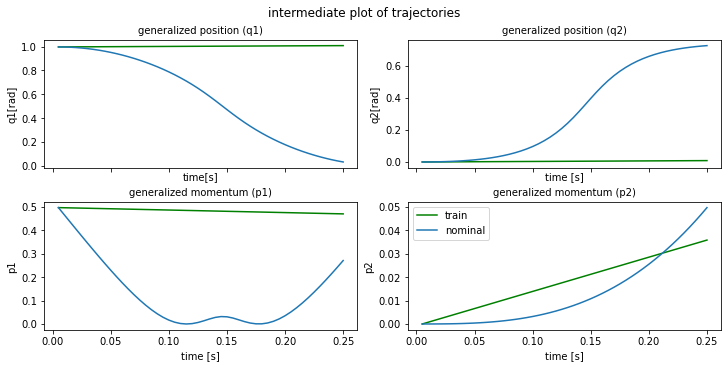

plot time : 0.6356368064880371
epoch    0 | train time 3.28 | train loss 4.043246e-01 
epoch    1 | train time 2.67 | train loss 3.990547e-01 
epoch    2 | train time 2.46 | train loss 3.927431e-01 
epoch    3 | train time 2.57 | train loss 3.844723e-01 
epoch    4 | train time 2.63 | train loss 3.734621e-01 
epoch    5 | train time 2.66 | train loss 3.590482e-01 
epoch    6 | train time 2.36 | train loss 3.408076e-01 


KeyboardInterrupt: 

In [459]:
stats = train(model=model,
              Ts=Ts,
              train_loader=train_loader,
              test_loader=test_loader,
              w=torch.tensor(weights, device=device),
              grad_clip=grad_clip,
              lr_schedule=lr_schedule,
              begin_decay=begin_decay,
              resnet_config=None,
              epoch_number=epoch_number,
              alternating=False,
              horizon=False,
              horizon_type='auto',
              horizon_list=horizon_list,
              switch_steps=switch_steps,
              epochs=epoch_number,
              loss_type='L2',
              collect_grads=False,
              rescale_loss=True,
              rescale_dims=[1, 1, 1, 1])

In [ ]:
# save model to disk
model_path = 'data/models/'+save_prefix+'model_test'
torch.save(model.state_dict(), PATH+model_path)

# save the stats
stats_path = PATH+'data/stats/'+save_prefix+'stats.txt'
save_stats(stats, stats_path)

#### Resnet config 1

In [363]:
device = set_device()
furuta_type = 'real'  # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(
    which=furuta_type)
# C_q1, C_q2 = 0.000009, 0.00004
utype = 'sine'  # 'chirp' or None or '' or ''
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 5  # 4 # 1.4
u_func.params['scale'] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'
g_func = G_FUNC(gtype=gtype)
init_method = 'random_closetopi'  # 'random_nozero' # 'random_closetopi'
time_steps = 800
num_trajectories = 1
proportion = 0.0
batch_size = 100
w_rescale = [1, 10000, 1, 100000]  # [1, 9000, 1, 10000] # [1,1,1,1]#
coord_type = 'hamiltonian'
min_max_rescale = False
rescale_dims = [1, 1, 1, 1]
shuffle = False
train_loader, test_loader = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims = rescale_dims)


cpu


In [364]:
# horizon_list = [20,40,60]
# switch_steps = [200,200,200]
horizon_list = [50,100,150]
switch_steps = [300,300,300]
epoch_number = sum(switch_steps)
grad_clip = True # activate gradient clipping
lr_schedule = False # activate lr schedule
begin_decay = 2250 # epoch at which lr starts decaying

model_name = 'NESHDNN_resnet_conf1'

H_net = ResNet_config1(resblock_list=[0], num_blocks = 6, input_dim=4, hidden_dim=40, 
                nb_hidden_layers=2, output_dim=1, activation_res='x+sin(x)^2', activation_mlp='x+sin(x)^2')
num_params = 0
for block in H_net.resblocks:
    block.to(device)
    num_params += count_parameters(block)

model = Nes_HDNN(u_func=u_func, G_net=g_func, H_net=H_net, device=device, dissip=False)
model.to(device)
num_params1 = count_parameters(model)
num_params2 = count_parameters(model.H_net.resblocks[0])
num_params += num_params1

weights = [1.0, 1.0, 1.0, 1.0] 
weights_title = ' | weights = ' + str(weights)

save_prefix = '{:d}e_w{:05.1f}_{:05.1f}_{:05.1f}_{:05.1f}_p{:d}k_Ts{:1.3f}_'.format(epoch_number,weights[0],weights[1],weights[2],weights[3],int((num_params-num_params%1000)/1000),Ts)
if utype is None:
    input = 'noinput'
else :
    input = utype
save_prefix = model_name +'_'+ input + '_' + str(num_trajectories)+'traj'+'_' + furuta_type + '_' + 'noise'+str(noise_std)+'_'+  save_prefix 
if grad_clip:
    save_prefix = save_prefix + 'gradcl_'
if lr_schedule: 
    save_prefix = save_prefix + 'lrsched_'
if C_q1==0 and C_q2==0:
    save_prefix = save_prefix + 'nodissip'
else:
    save_prefix = save_prefix + 'wdissip'

print('Total number of epochs:', epoch_number)
print('mlp number of parameters :', num_params1)
print('resblock number of parameters :', num_params2)
print('Total number of H_net parameters :', num_params)
print('Save file prefix : ', save_prefix)

if len(horizon_list) == len(switch_steps) :
    print('horizon_list and switch_steps have the same size ')
else:
    raise ValueError('horizon_list and switch_steps do NOT have the same size ',len(horizon_list),len(switch_steps))

Total number of epochs: 310
mlp number of parameters : 3523
resblock number of parameters : 3401
Total number of H_net parameters : 23929
Save file prefix :  NESHDNN_resnet_conf1_sine_1traj_real_noise0.0_310e_w001.0_001.0_001.0_001.0_p23k_Ts0.005_gradcl_nodissip
horizon_list and switch_steps have the same size 


In [365]:
model.H_net.resblock_list

[0]

In [ ]:
stats = train(model=model,
            Ts=Ts,
            train_loader=train_loader,
            test_loader=test_loader,
            w=torch.tensor(weights, device=device),
            grad_clip=grad_clip,
            lr_schedule=lr_schedule,
            begin_decay=begin_decay,
            resnet_config=1,
            epoch_number=epoch_number,
            alternating=False,
            horizon=False,
            horizon_type='auto',
            horizon_list=horizon_list,
            switch_steps=switch_steps,
            epochs=epoch_number,
            loss_type='L2weighted',
            collect_grads=False,
            rescale_loss = True,
            rescale_dims = [1, 1, 1, 1])


In [ ]:
# save model to disk
model_path = 'data/models/'+save_prefix+'model_test'
torch.save(model.state_dict(), PATH+model_path)

# save the stats
stats_path = PATH+'data/stats/'+save_prefix+'stats.txt'
save_stats(stats, stats_path)

#### Resnet config 2

In [395]:
device = set_device()
furuta_type = 'real' # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = furuta_type) 

utype = 'chirp' #  'chirp' or None or '' or ''
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 4 # 4 # 1.4
u_func.params['scale'] = 0.001 # for fake : 0.5 or 0.1 for real : 0.0001
gtype='simple'
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero' # 'random_nozero' # 'random_closetopi'
time_steps= 800
num_trajectories = 1
proportion = 0.0
batch_size = 100
w_rescale = [1, 1000, 1, 10000] # [1, 9000, 1, 10000]
coord_type = 'hamiltonian'
min_max_rescale = False
rescale_dims = [1, 1, 1, 1]
shuffle = False
train_loader, test_loader = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims = rescale_dims)

cpu


In [396]:
model.H_net.resblocks[0]

MLP(
  (fc1): Linear(in_features=4, out_features=70, bias=True)
  (hidden_layers): Sequential(
    (0): hidden_Layer(
      (fc): Linear(in_features=70, out_features=70, bias=True)
    )
    (1): hidden_Layer(
      (fc): Linear(in_features=70, out_features=70, bias=True)
    )
  )
  (fc2): Linear(in_features=70, out_features=4, bias=True)
)

In [397]:
# horizon_list = [50,100,150,200]
# switch_steps = [200,200,100,100]
horizon_list = [50,100,150,200,250,300]
switch_steps = [5,5,5,5,5,5]
epoch_number = sum(switch_steps)
grad_clip = True # activate gradient clipping
lr_schedule = False # activate lr schedule
begin_decay = 2250 # epoch at which lr starts decaying

model_name = 'NESHDNN_resnet_conf2'

H_net = ResNet_config2(resblock_list = [0,16], num_blocks = 17, input_dim=4, 
                       hidden_dim=45, nb_hidden_layers=1, output_dim=1, 
                       activation_res='x+sin(x)^2', activation_mlp='x+sin(x)^2')
num_params = 0
for block in H_net.resblocks:
    block.to(device)
    num_params += count_parameters(block)

model = Nes_HDNN(u_func=u_func, G_net=g_func, H_net=H_net, device=device, dissip=False)
model.to(device)
num_params1 = count_parameters(model)
num_params2 = count_parameters(model.H_net.resblocks[0])
num_params += num_params1
weights = [1.0, 1.0, 1.0, 1.0] 
weights_title = ' | weights = ' + str(weights)

save_prefix = '{:d}e_w{:05.1f}_{:05.1f}_{:05.1f}_{:05.1f}_p{:d}k_Ts{:1.3f}_'.format(epoch_number,weights[0],weights[1],weights[2],weights[3],int((num_params-num_params%1000)/1000),Ts)
if utype is None:
    input = 'noinput'
else :
    input = utype 
save_prefix = model_name +'_'+ input + '_' + str(num_trajectories)+'traj'+'_' + furuta_type + '_' + 'noise'+str(noise_std)+'_'+  save_prefix 
if grad_clip: 
    save_prefix = save_prefix + 'gradcl_'
if lr_schedule: 
    save_prefix = save_prefix + 'lrsched_'
if C_q1==0 and C_q2==0:
    save_prefix = save_prefix + 'nodissip'
else:
    save_prefix = save_prefix + 'wdissip'

print('Total number of epochs:',epoch_number)
print('mlp number of parameters :', num_params1)
print('resblock number of parameters :', num_params2)
print('Total number of parameters :', num_params)

print('Save file prefix : ', save_prefix)

if len(horizon_list) == len(switch_steps) :
    print('horizon_list and switch_steps have the same size ')
else:
    raise ValueError('horizon_list and switch_steps do NOT have the same size ',len(horizon_list),len(switch_steps))

Total number of epochs: 30
mlp number of parameters : 2343
resblock number of parameters : 2479
Total number of parameters : 44486
Save file prefix :  NESHDNN_resnet_conf2_chirp_1traj_real_noise0.0_30e_w001.0_001.0_001.0_001.0_p44k_Ts0.005_gradcl_nodissip
horizon_list and switch_steps have the same size 


In [382]:
model.H_net.resblock_list

[0, 16]

In [398]:
stats = train(model = model, 
            Ts = Ts, 
            train_loader = train_loader, 
            test_loader = test_loader, 
            w=torch.tensor(weights, device=device),
            grad_clip = grad_clip,
            lr_schedule = lr_schedule,
            begin_decay = begin_decay, 
            resnet_config = 2,
            epoch_number = epoch_number, 
            alternating = False,
            horizon = False, 
            horizon_type = 'auto', 
            horizon_list = horizon_list, 
            switch_steps = switch_steps, 
            epochs = epoch_number, 
            loss_type = 'L2weighted',
            collect_grads=False)

horizon length : 50
Model size increased


RuntimeError: number of dims don't match in permute

In [ ]:
# save model to disk
model_path = 'data/models/'+save_prefix+'model_test'
torch.save(model.state_dict(), PATH+model_path)

# save the stats
stats_path = PATH+'data/stats/'+save_prefix+'stats.txt'
save_stats(stats, stats_path)

## Resnet config 3

In [384]:
device = set_device()
furuta_type = 'real' # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = furuta_type) 
# C_q1, C_q2 = 0.000009, 0.00004
utype = 'sine' #  'chirp' or None or '' or ''
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 5 # 4 # 1.4
u_func.params['scale'] = 0.0001 # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'
g_func = G_FUNC(gtype=gtype)
init_method = 'random_closetopi' # 'random_nozero' # 'random_closetopi'
time_steps= 800
num_trajectories = 5
proportion = 0.0
batch_size = 100
w_rescale = [1, 10000, 1, 100000] # [1, 9000, 1, 10000] # [1,1,1,1]#
coord_type = 'hamiltonian'
min_max_rescale = False
rescale_dims = [1, 1, 1, 1]
shuffle = False
train_loader, test_loader = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims = rescale_dims)

cpu


In [388]:
# horizon_list = [20,40,60]
# switch_steps = [200,200,200]
horizon_list = [50,100,150]
switch_steps = [5,5,300]
epoch_number = sum(switch_steps)
grad_clip = True # activate gradient clipping
lr_schedule = False # activate lr schedule
begin_decay = 2250 # epoch at which lr starts decaying

model_name = 'NESHDNN_resnet_conf3'

H_net = ResNet_config3(resblock_list=[0], num_blocks = 6, input_dim=4, hidden_dim=70, 
                nb_hidden_layers=2, output_dim=1, activation_res='x+sin(x)^2', activation_mlp='x+sin(x)^2')
num_params = 0
for block in H_net.resblocks:
    block.to(device)
    num_params += count_parameters(block)

model = Nes_HDNN(u_func=u_func, G_net=g_func, H_net=H_net, device=device, dissip=False)
model.to(device)
num_params1 = count_parameters(model)
num_params2 = count_parameters(model.H_net.resblocks[0])
num_params += num_params1

weights = [1.0, 1.0, 1.0, 1.0] 
weights_title = ' | weights = ' + str(weights)

save_prefix = '{:d}e_w{:05.1f}_{:05.1f}_{:05.1f}_{:05.1f}_p{:d}k_Ts{:1.3f}_'.format(epoch_number,weights[0],weights[1],weights[2],weights[3],int((num_params-num_params%1000)/1000),Ts)
if utype is None:
    input = 'noinput'
else :
    input = utype
save_prefix = model_name +'_'+ input + '_' + str(num_trajectories)+'traj'+'_' + furuta_type + '_' + 'noise'+str(noise_std)+'_'+  save_prefix 
if grad_clip:
    save_prefix = save_prefix + 'gradcl_'
if lr_schedule: 
    save_prefix = save_prefix + 'lrsched_'
if C_q1==0 and C_q2==0:
    save_prefix = save_prefix + 'nodissip_'
else:
    save_prefix = save_prefix + 'wdissip'

print('Total number of epochs:', epoch_number)
print('mlp number of parameters :', num_params1)
print('resblock number of parameters :', num_params2)
print('Total number of H_net parameters :', num_params)
print('Save file prefix : ', save_prefix)

if len(horizon_list) == len(switch_steps) :
    print('horizon_list and switch_steps have the same size ')
else:
    raise ValueError('horizon_list and switch_steps do NOT have the same size ',len(horizon_list),len(switch_steps))

Total number of epochs: 310
mlp number of parameters : 10363
resblock number of parameters : 10574
Total number of H_net parameters : 73807
Save file prefix :  NESHDNN_resnet_conf3_sine_5traj_real_noise0.0_310e_w001.0_001.0_001.0_001.0_p73k_Ts0.005_gradcl_nodissip_
horizon_list and switch_steps have the same size 


In [389]:
# model_path = 'data/models/'+save_prefix+'model_test'
# model.load_state_dict(torch.load(PATH+model_path))
# model.eval()
# model.to(device)
# model.H_net.resblock_list

horizon length : 50
Model size increased


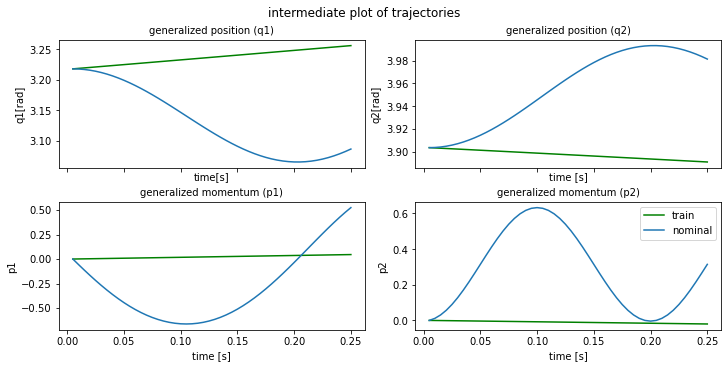

plot time : 0.5966579914093018
epoch    0 | train time 1.22 | train loss 1.351382e+00 
epoch    1 | train time 0.58 | train loss 1.329894e+00 
epoch    2 | train time 0.75 | train loss 1.311581e+00 
epoch    3 | train time 0.62 | train loss 1.294755e+00 
epoch    4 | train time 0.57 | train loss 1.278269e+00 
horizon length : 100
Model size increased


KeyboardInterrupt: 

In [390]:
stats = train(model = model, 
            Ts = Ts, 
            train_loader = train_loader, 
            test_loader = test_loader, 
            w=torch.tensor(weights, device=device),
            grad_clip = grad_clip,
            lr_schedule = lr_schedule,
            begin_decay = begin_decay, 
            resnet_config = 1,
            epoch_number = epoch_number, 
            alternating = False,
            horizon = False, 
            horizon_type = 'auto', 
            horizon_list = horizon_list, 
            switch_steps = switch_steps, 
            epochs = epoch_number, 
            loss_type = 'L2weighted',
            collect_grads = False)

In [ ]:
# save model to disk
model_path = 'data/models/'+save_prefix+'model_test'
torch.save(model.state_dict(), PATH+model_path)

# save the stats
stats_path = PATH+'data/stats/'+save_prefix+'stats.txt'
save_stats(stats, stats_path)

# Loading models and stats

In [ ]:
save_prefix = save_prefix +'multitrajwinput'

In [ ]:
stats_path = PATH+'data/stats/'+save_prefix+'stats.txt'

In [ ]:
# # save the stats
# save_stats(PATH, stats, stats_path)

In [ ]:
# loads the stats 
stats = read_dict(PATH, stats_path)

In [ ]:
# # save model to disk
# model_path = 'data/models/'+save_prefix+'model_test'
# torch.save(model.state_dict(), PATH+model_path)

In [ ]:
model_path = 'models/'+save_prefix+'model_test_latest'
# load the model from disk
model = load_model_nes_hdnn(device,utype=utype, u_func=u_func, hidden_dim=90, nb_hidden_layers=4) # load_model(hidden_dim=90, nb_hidden_layers=4)
#load_model(device, hidden_dim=90, nb_hidden_layers=4)
model.load_state_dict(torch.load(PATH+model_path))
model.eval()

In [ ]:
print(model.C2_dissip)
print(model.C1_dissip)

# Plots of results

In [ ]:
loss_train = stats['train_loss']
loss_test = stats['test_loss']
epochs = np.arange(len(loss_train))
train_test_loss_plot(loss_train, loss_test, epochs, file_path=PATH+'data/img/'+save_prefix+'LOSS_train_test.png', 
                     title='train and test loss per epoch', horizons = False )

train_test_loss_plot(loss_train, loss_test, epochs, file_path=PATH+'data/img/'+save_prefix+'LOSS_train_test_warrows.png', 
                     title='train and test loss per epoch', horizons = horizon_list[:-1], horizon_steps = horizon_steps )

In [ ]:
model.u_func = u_func
model.G_net = g_func

In [ ]:
# show train and prediction
title = 'Train set trajectories ' # | Nes_HDNN with chirp input and multi-level strategy 3
for n in [0,5,10,19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader, 
                        t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=300, show_pred=True, H_or_Input = 'input',
                        title = title, file_path=None)

In [ ]:
# show train and prediction
for n in [0,5,10,19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader, 
                        t_max=200, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=300, show_pred=True, H_or_Input = 'input',
                        title = 'Train set trajectories', file_path=PATH+'data/img/'+save_prefix+'TRAJECTORIES_train_set'+str(n)+'_nopred.png')

In [ ]:
# show only training portion
for n in [0,50,70,80]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader, t_max=300, 
    n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp, t_plot=300, show_pred=False,
    title = 'Train set trajectories', file_path=PATH+'data/img/'+save_prefix+'TRAJECTORIES_train_set'+str(n)+'.png')

In [ ]:
device = set_device()
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = 'fake') # 'fake'
utype = None
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 10 #4 # 1.4
u_func.params['scale'] = 1.0 # 0.1
gtype=None
g_func = G_FUNC(gtype=gtype)
init_method = 'random_closetopi' # 'random_nozero' # 'random_closetopi'
time_steps= 800
num_trajectories = 1

In [ ]:
device = set_device()
furuta_type = 'real'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = furuta_type) # 'fake'
utype = None
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 4 # 4 # 1.4
u_func.params['scale'] = 0.001 # for fake : 0.5 or 0.1 for real : 0.0001
gtype=None
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero' # 'random_nozero' # 'random_closetopi'
time_steps= 1000
num_trajectories = 5
proportion = 0.0
batch_size = 100
w_rescale = [1, 1000, 1, 10000] # [1, 9000, 1, 10000]

train_loader_2, test_loader_2 = load_data_device(device, init_method, w_rescale,
                                            u_func, g_func, time_steps, 
                                            shuffle = False, 
                                            num_trajectories = num_trajectories, 
                                            coord_type = 'hamiltonian', 
                                            proportion = proportion, batch_size = batch_size, 
                                            Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2, 
                                            g = g, Jr = Jr, Lr = Lr, Mp = Mp, Lp = Lp,)
model.u_func = u_func
model.G_net = g_func

In [ ]:
for n in [0,1,2,3,4]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader_2, t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp, only_pred = True,
                        title = 'Train set trajectories | no input', 
                        file_path=PATH+'data/img/'+save_prefix+'TRAJECTORIES_train_set'+str(n)+'_noinput.png')


In [ ]:
device = set_device()
furuta_type = 'real'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = furuta_type) # 'fake'
utype = 'chirp'
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 10 # 4 # 1.4
u_func.params['scale'] = 0.001 # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero' # 'random_nozero' # 'random_closetopi'
time_steps= 1000
num_trajectories = 1
proportion = 0.0
batch_size = 100
w_rescale = [1, 1000, 1, 10000] # [1, 9000, 1, 10000]

train_loader_3, test_loader_3 = load_data_device(device, init_method, w_rescale,
                                            u_func, g_func, time_steps, 
                                            shuffle = False, 
                                            num_trajectories = num_trajectories, 
                                            coord_type = 'hamiltonian', 
                                            proportion = proportion, batch_size = batch_size, 
                                            Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2, 
                                            g = g, Jr = Jr, Lr = Lr, Mp = Mp, Lp = Lp)
model.u_func = u_func
model.G_net = g_func

In [ ]:
for n in [0,5,9]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader_3, t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp, only_pred = True,
                        title = 'Test set trajectories | sine input (1hz)', file_path=PATH+'data/img/'+save_prefix+'TRAJECTORIES_train_set'+str(n)+'_sineinput.png')

In [ ]:
device = set_device()
furuta_type = 'real'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = furuta_type) # 'fake'
utype = None
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 4 # 4 # 1.4
u_func.params['scale'] = 0.001 # for fake : 0.5 or 0.1 for real : 0.0001
gtype = None
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero' # 'random_nozero' # 'random_closetopi'
time_steps= 1000
num_trajectories = 1
proportion = 0.0
batch_size = 100
w_rescale = [1, 1000, 1, 10000] # [1, 9000, 1, 10000]

train_loader_4, test_loader_4 = load_data_device(device, init_method, w_rescale,
                                            u_func, g_func, time_steps, 
                                            shuffle = False, 
                                            num_trajectories = num_trajectories, 
                                            coord_type = 'hamiltonian', 
                                            proportion = proportion, batch_size = batch_size, 
                                            Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2, 
                                            g = g, Jr = Jr, Lr = Lr, Mp = Mp, Lp = Lp)
model.u_func = u_func 
model.G_net = g_func 

In [ ]:
for n in [0]:
    plot_longer_horizon_furuta(device, model, u_func, g_func, utype, gtype, test_loader=train_loader_4,n=n,
                                t1=0,t2=600, C_q1= C_q1, C_q2= C_q2, g= g, Jr= Jr, Lr= Lr, Mp= Mp, Lp= Lp, 
                                title = 'Trajectory after longer horizon',
                                file_path = PATH+'img/'+save_prefix+'TRAJ_longer_horizon1.png')